# Incermental Data Analisys

in this notebook we will incrementally add data, look at model performance and then analyze the data to try to improve model performance at every step of the way. 

# Helping functions and constants

In [ ]:
!pip install shap xgboost

In [1]:
MAX_CUTOFF_YEAR = 2023

In [2]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

def split_train_test_by_cutoff_years(df, model, target_col, feature_cols, cutoff_years=[2015, 2016, 2017, 2018, 2019]):
    """
    Splits the dataset based on cutoff years, trains a model on each, and returns results.

    Parameters:
        df (pd.DataFrame): Original dataframe with 'publication_date'.
        model: A scikit-learn compatible estimator (e.g. DecisionTreeClassifier).
        target_col (str): Target column name.
        feature_cols (list): List of feature column names.
        cutoff_years (list): List of years where data before is training and from the year onward is test.

    Returns:
        List of result dictionaries per split with:
            - 'cutoff_year'
            - 'train_size', 'test_size'
            - 'accuracy'
            - 'y_true', 'y_pred'
            - 'feature_importances': list of (feature_name, importance)
    """
    df = df.copy()
    df['publication_date'] = pd.to_datetime(df['publication_date'], errors='coerce')
    df = df[df['publication_date'].dt.year <= MAX_CUTOFF_YEAR]  # Filter up to and including 2023
    df = df.sort_values('publication_date')

    results = []

    for cutoff in cutoff_years:
        df_train = df[df['publication_date'].dt.year < cutoff]
        df_test = df[df['publication_date'].dt.year >= cutoff]

        if df_train.empty or df_test.empty:
            print(f"Skipping year {cutoff} due to empty train/test split.")
            continue

        X_train = df_train[feature_cols]
        y_train = df_train[target_col]
        X_test = df_test[feature_cols]
        y_test = df_test[target_col]

        clf = DecisionTreeClassifier()  # no max_depth for now
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        feature_importances = sorted(
            zip(feature_cols, clf.feature_importances_),
            key=lambda x: x[1], reverse=True
        )

        results.append({
            'cutoff_year': cutoff,
            'train_size': len(df_train),
            'test_size': len(df_test),
            'accuracy': accuracy_score(y_test, y_pred),
            'y_true': y_test.values,
            'y_pred': y_pred,
            'feature_importances': feature_importances
        })

    return results


In [3]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Extended function to plot performance metrics AND feature importances per split year
def plot_metrics_and_feature_importances(results, top_n_features=5):
    years = [res['cutoff_year'] for res in results]
    accuracies = [res['accuracy'] for res in results]
    precisions = [precision_score(res['y_true'], res['y_pred'], average='macro', zero_division=0) for res in results]
    recalls = [recall_score(res['y_true'], res['y_pred'], average='macro', zero_division=0) for res in results]
    f1s = [f1_score(res['y_true'], res['y_pred'], average='macro', zero_division=0) for res in results]

    def plot_metric(values, title, ylabel):
        plt.figure(figsize=(8, 5))
        plt.bar(years, values)
        plt.title(title)
        plt.xlabel("Cutoff Year")
        plt.ylabel(ylabel)
        plt.xticks(years)
        plt.tight_layout()
        plt.show()

    # Plot metrics
    plot_metric(accuracies, "Accuracy per Split Year", "Accuracy")
    plot_metric(precisions, "Precision per Split Year", "Precision")
    plot_metric(recalls, "Recall per Split Year", "Recall")
    plot_metric(f1s, "F1 Score per Split Year", "F1 Score")

    # Plot top feature importances per split year
    for res in results:
        cutoff_year = res['cutoff_year']
        features, importances = zip(*res['feature_importances'][:top_n_features])
        plt.figure(figsize=(8, 5))
        plt.barh(features, importances)
        plt.title(f"Top {top_n_features} Feature Importances - Cutoff {cutoff_year}")
        plt.xlabel("Importance")
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()


In [93]:
import numpy as np
import matplotlib.pyplot as plt
import shap

def plot_signed_shap_bar(shap_values, feature_names, max_display=20):
    # Calculate mean SHAP value for each feature
    mean_shap = np.mean(shap_values, axis=0)  # mean over samples (signed)

    # Sort by absolute magnitude
    sorted_idx = np.argsort(np.abs(mean_shap))[::-1][:max_display]
    sorted_features = np.array(feature_names)[sorted_idx]
    sorted_shap = mean_shap[sorted_idx]

    plt.figure(figsize=(10, 6))
    bars = plt.barh(sorted_features, sorted_shap)
    plt.xlabel("Mean SHAP Value (Impact on Model Output)")
    plt.title("Top Features - Signed SHAP Values")
    plt.gca().invert_yaxis()
    
    # Color positive and negative bars differently
    for bar, val in zip(bars, sorted_shap):
        if val > 0:
            bar.set_color('steelblue')
        else:
            bar.set_color('salmon')

    plt.tight_layout()
    plt.show()


In [126]:
# 🚀 FINAL FULL SOLUTION: XGBoost + Correct SHAP + Signed Bar Plots (Per Class) + Dependence Plots

import pandas as pd
import shap
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
import numpy as np

def shap_summary_best_f1_xgboost(results, df, target_col, feature_exclude_cols=['publication_date', 'application_number', 'value_imputed'], sample_size=300, max_display=20):
    # 1. Get best F1 split
    best_index = max(range(len(results)),
                     key=lambda i: f1_score(results[i]['y_true'], results[i]['y_pred'], average='macro', zero_division=0))
    best_cutoff_year = results[best_index]['cutoff_year']
    print(f"Best F1 score at cutoff year: {best_cutoff_year}")

    # 2. Prepare dataset
    df_copy = df.copy()
    df_copy['publication_date'] = pd.to_datetime(df_copy['publication_date'], errors='coerce')
    df_copy = df_copy[df_copy['publication_date'].dt.year <= 2023]
    df_copy = df_copy.sort_values('publication_date')

    feature_cols = [c for c in df_copy.columns if c not in feature_exclude_cols + [target_col]]

    df_train = df_copy[df_copy['publication_date'].dt.year < best_cutoff_year]
    df_test = df_copy[df_copy['publication_date'].dt.year >= best_cutoff_year]

    X_train = df_train[feature_cols].astype(float)
    y_train = df_train[target_col]
    X_test = df_test[feature_cols].astype(float)
    y_test = df_test[target_col]

    # Remap labels for XGBoost
    label_mapping = {-1: 0, 0: 1, 1: 2}
    y_train = y_train.map(label_mapping)
    y_test = y_test.map(label_mapping)

    # 5. Train model
    model = XGBClassifier(
        objective='multi:softprob', 
        num_class=len(set(label_mapping.values())), 
        eval_metric='mlogloss',
        use_label_encoder=False,
        verbosity=0
    )
    model.fit(X_train, y_train)

    # 6. Sample
    X_sample = X_test.sample(n=min(sample_size, len(X_test)), random_state=42).astype(float)

    # 7. SHAP explanation using SHAP.Explainer correctly
    explainer = shap.Explainer(model, X_train)
    shap_values = explainer(X_sample)

    print(f"SHAP values shape: {shap_values.values.shape}")

    # 8. Plot per class
    reverse_mapping = {v: k for k, v in label_mapping.items()}

    for internal_class, original_label in reverse_mapping.items():
        shap_vals_for_class = shap_values.values[:, :, internal_class]  # (n_samples, n_features)
        mean_shap = np.mean(shap_vals_for_class, axis=0)

        sorted_idx = np.argsort(np.abs(mean_shap))[::-1][:max_display]
        sorted_features = np.array(X_sample.columns)[sorted_idx]
        sorted_shap = mean_shap[sorted_idx]

        plt.figure(figsize=(10, 6))
        bars = plt.barh(sorted_features, sorted_shap)
        plt.xlabel("Mean SHAP Value (Impact on Model Output)")
        plt.title(f"Top {max_display} Features Driving Class {original_label}")
        plt.gca().invert_yaxis()
        for bar, val in zip(bars, sorted_shap):
            if val > 0:
                bar.set_color('steelblue')
            else:
                bar.set_color('salmon')
        plt.tight_layout()
        plt.show()

    return model, explainer, shap_values, label_mapping


# Basic patent data

In [46]:
# DATA LOADING CELL
import pandas as pd

basic_patent_data = pd.read_csv('./Data/basic_patent_data_PATSTAT_IMPUTED_TARGET.csv',sep='\t',low_memory=False)

In [47]:
dropped_collumns_for_classification = ['application_number','filing_date','ipc_field','applicant_names','applicant_countries',
                                      'inventor_names','inventor_countries','representative_name',
                                       'representative_country','patent_granted','patent_granted_date','publication_number',
                                        'status','publication_types','status_text']

In [48]:
classification_basic_data_df = basic_patent_data.drop(columns = dropped_collumns_for_classification)

In [49]:
feature_cols = ['is_no_unity', 'is_incomplete_search', 'is_no_search']
target_col = 'application_status_target'

## No imputed values dropped

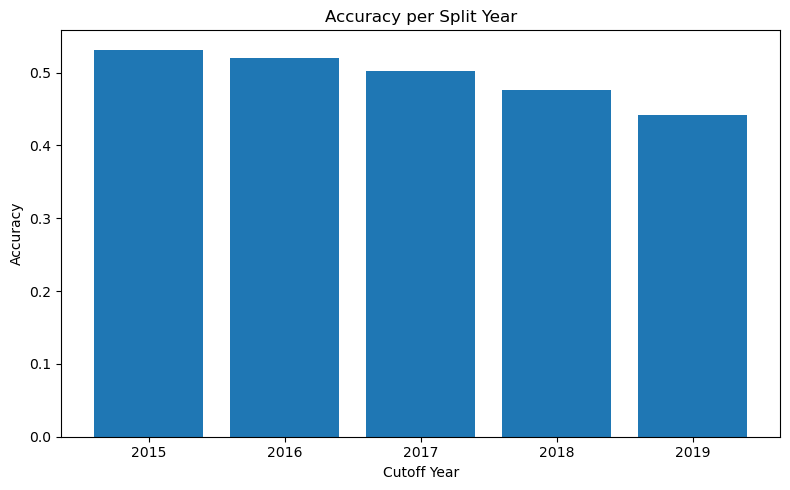

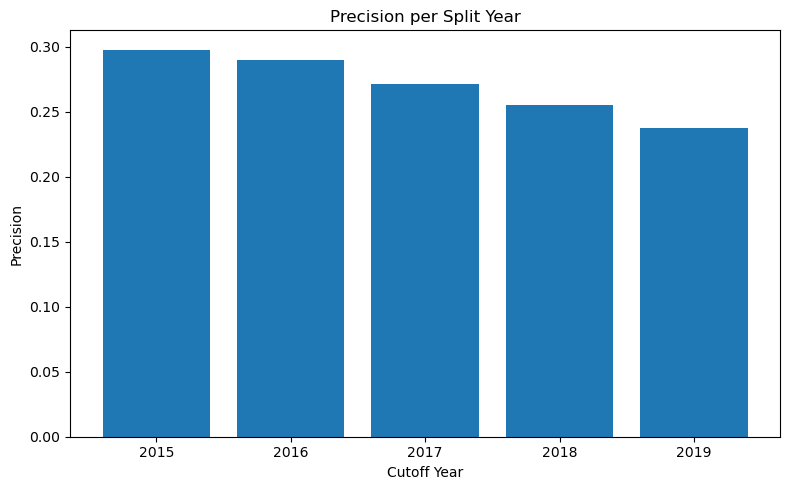

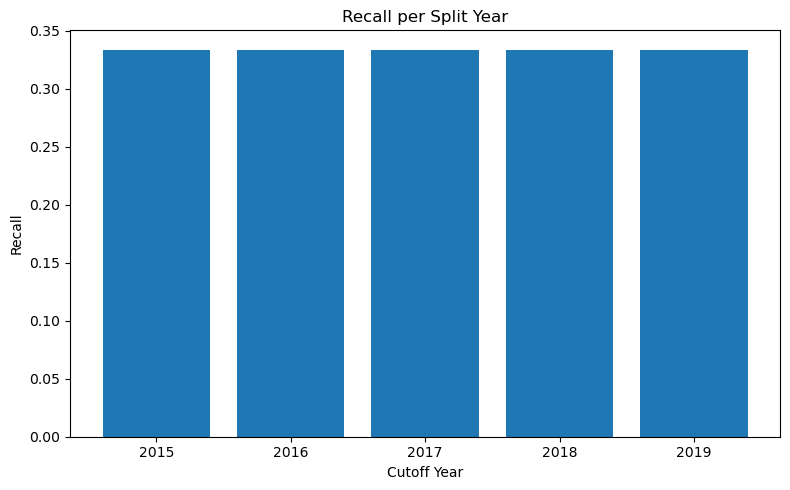

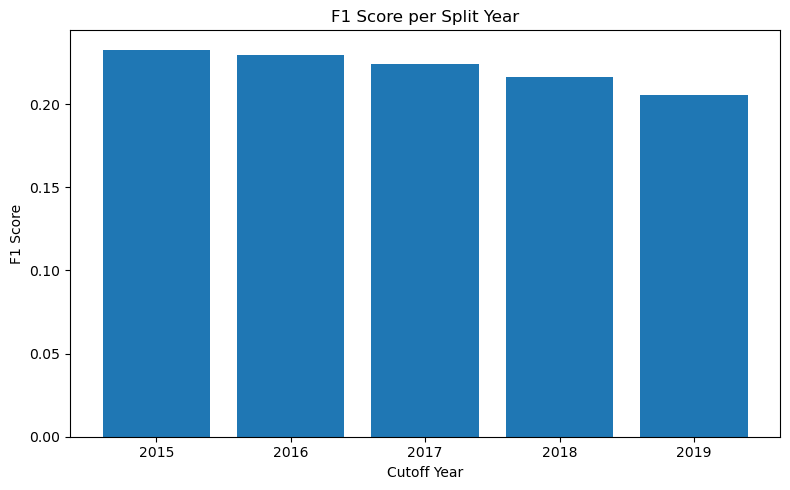

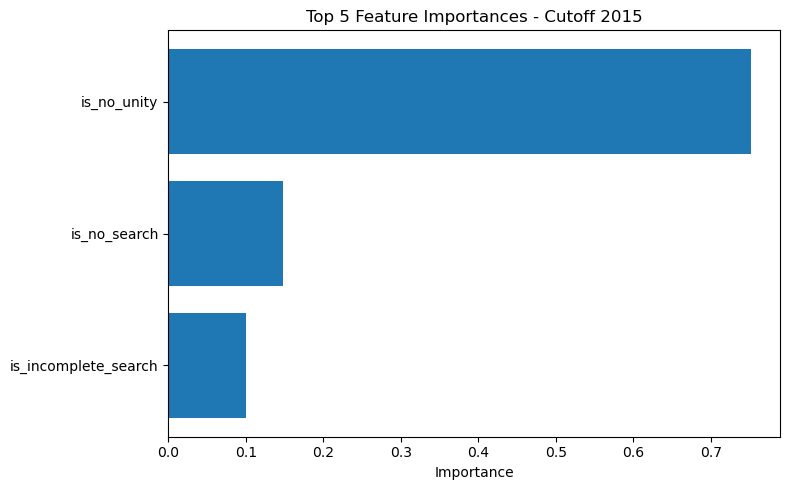

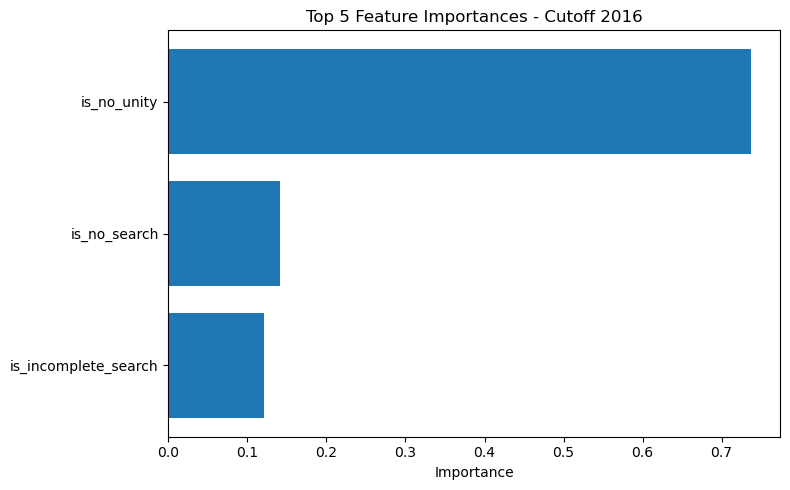

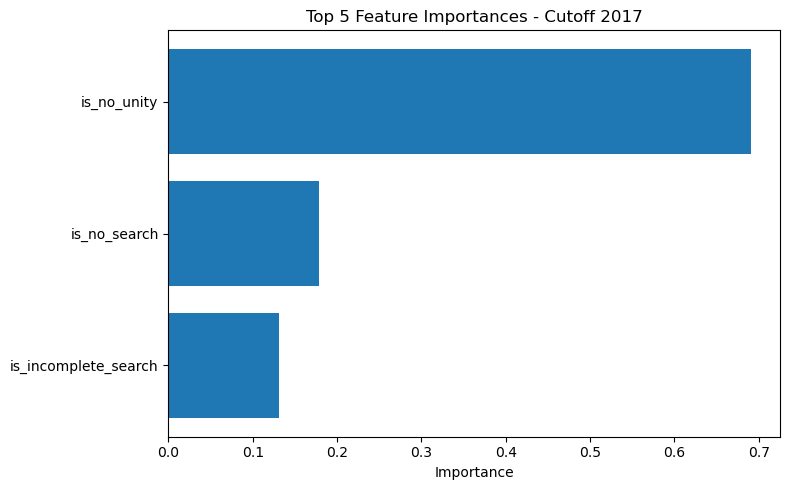

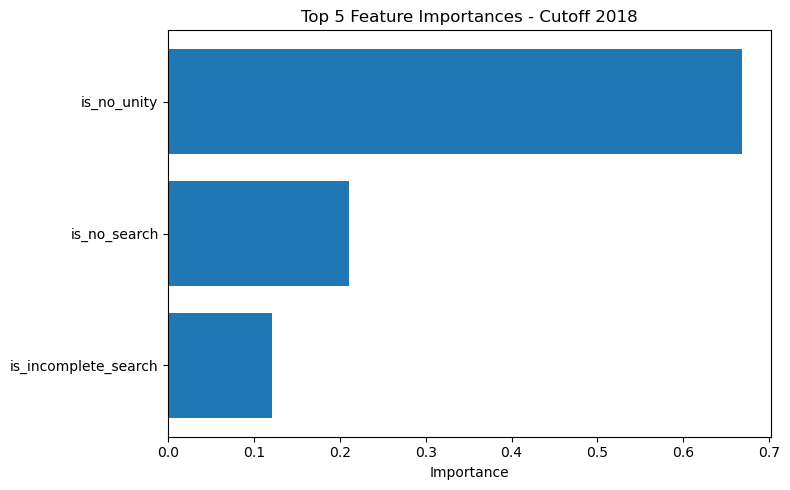

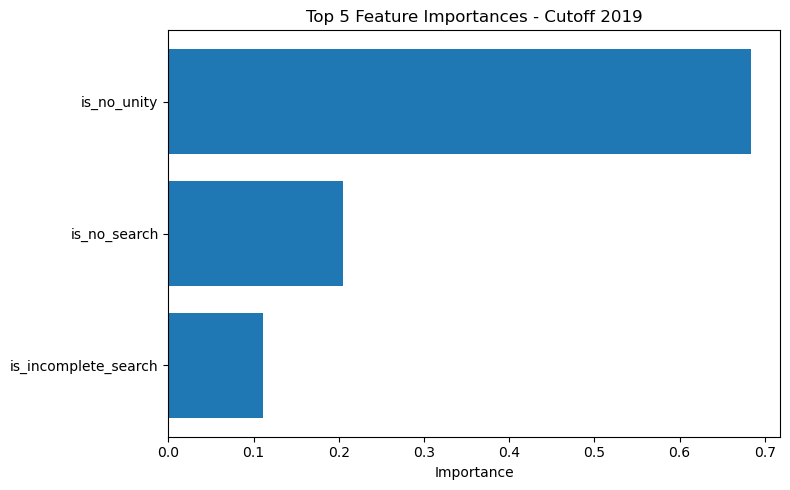

In [50]:
basic_patent_data_results = split_train_test_by_cutoff_years(
    df=basic_patent_data,
    model=DecisionTreeClassifier(),
    target_col=target_col,
    feature_cols=feature_cols
)

plot_metrics_and_feature_importances(basic_patent_data_results)

Best F1 score at cutoff year: 2015
Plotting SHAP summary for XGBoost...


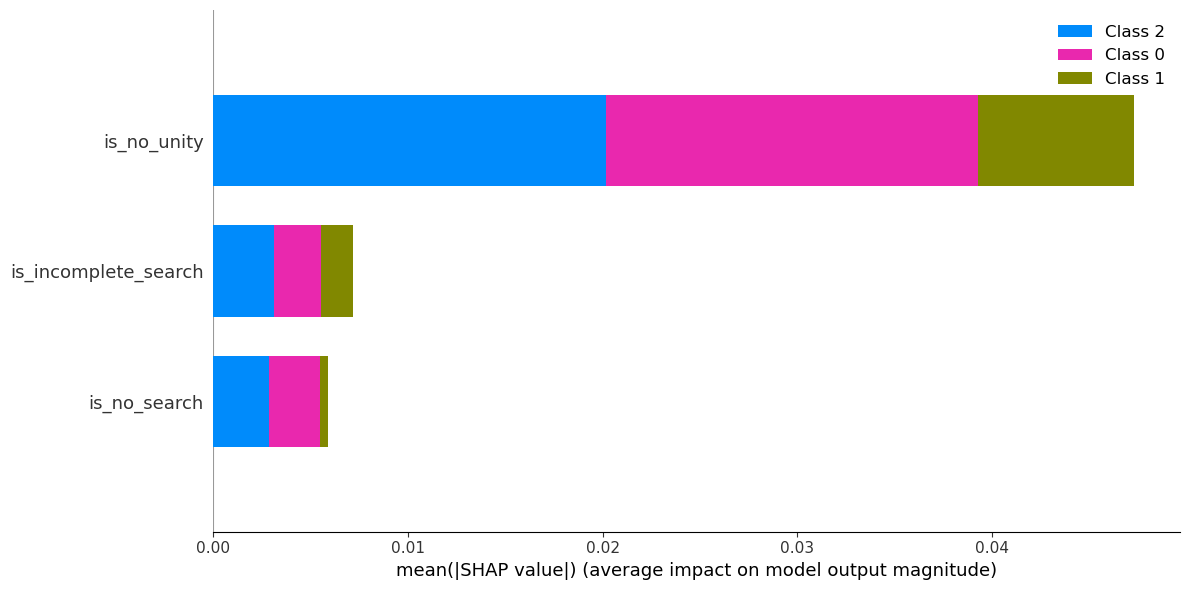

In [56]:
model, explainer, shap_values,label_mapping = shap_summary_best_f1_xgboost(
    results=basic_patent_data_results,
    df=classification_basic_data_df,
    target_col='application_status_target',  # adjust this if your label column is different
    feature_exclude_cols=['publication_date', 'application_number', 'value_imputed']
)


## Imputed values dropped

In [58]:
basic_dropped_df = classification_basic_data_df[classification_basic_data_df['value_imputed']==False]

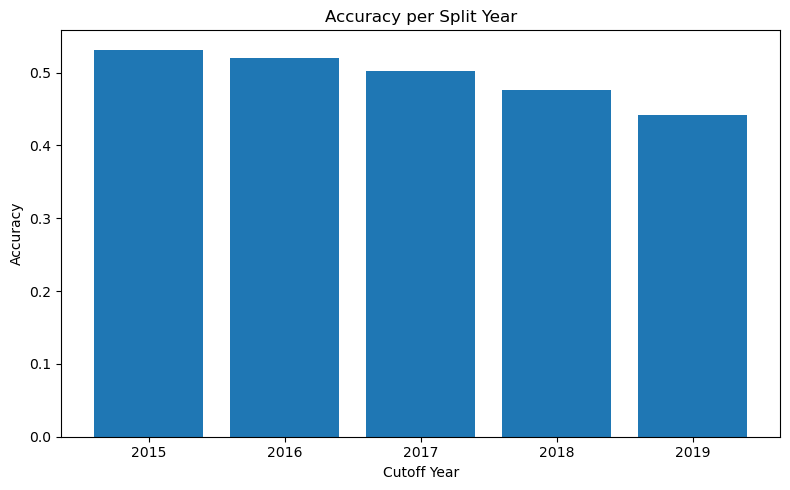

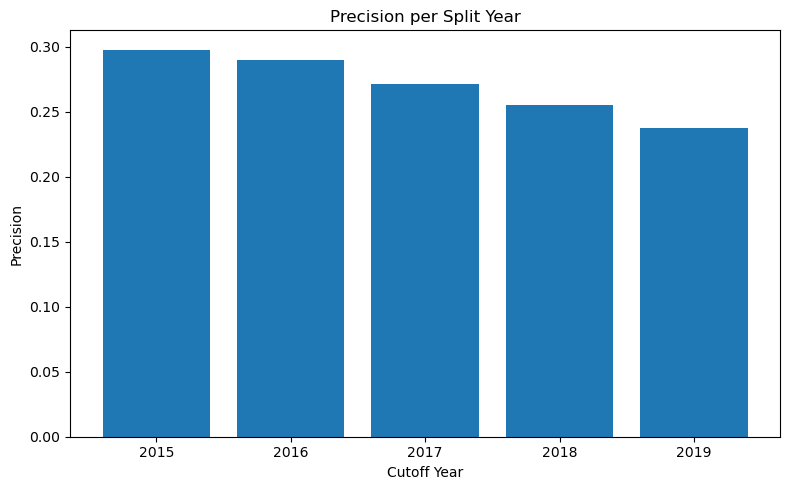

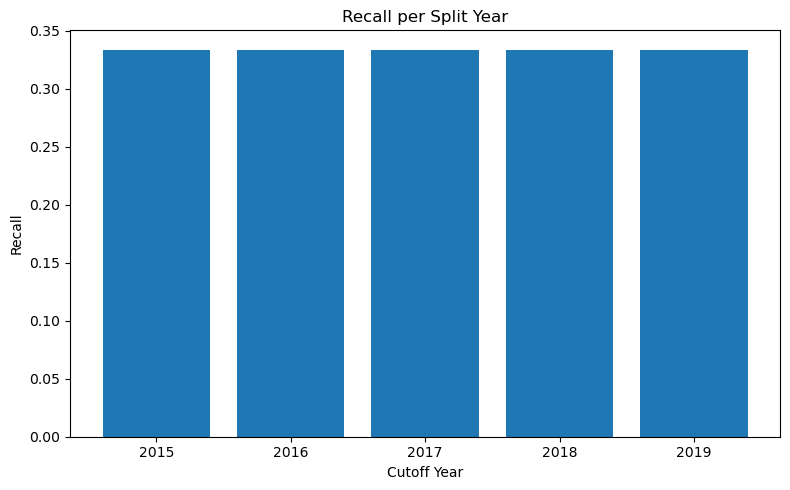

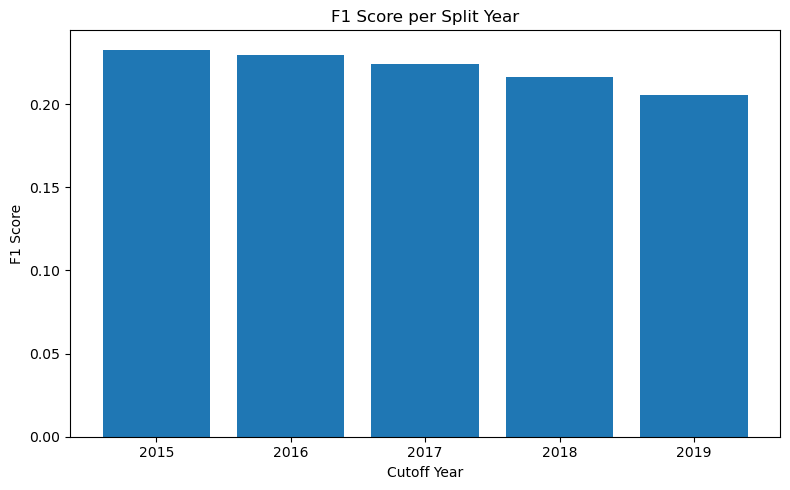

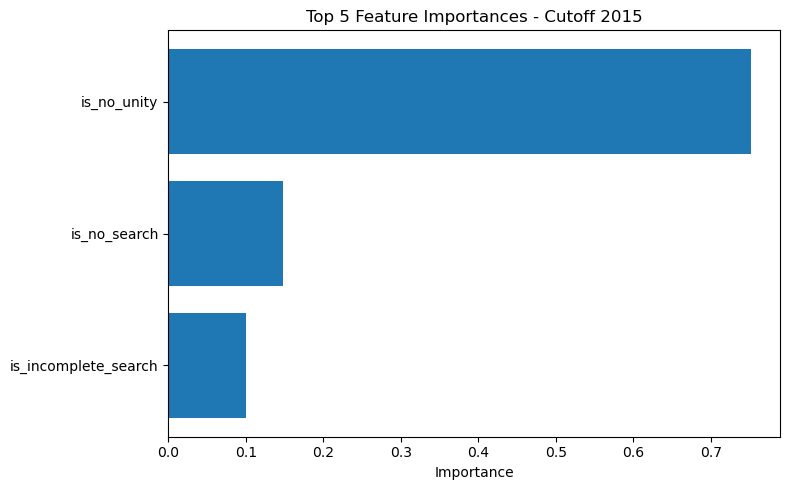

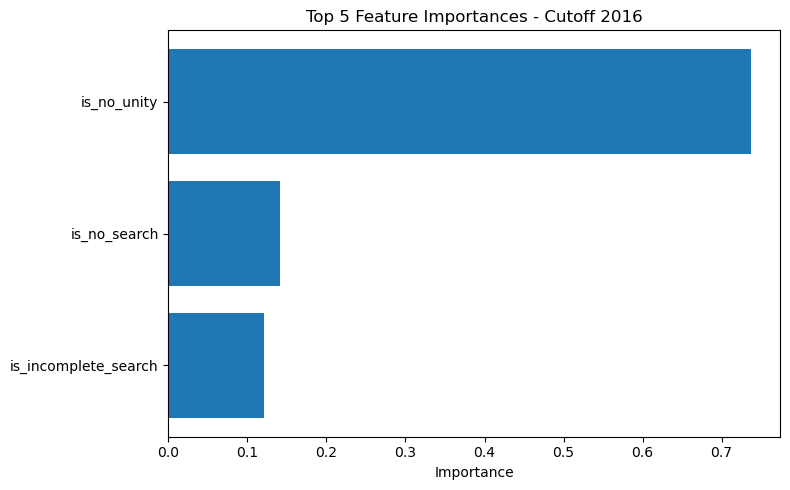

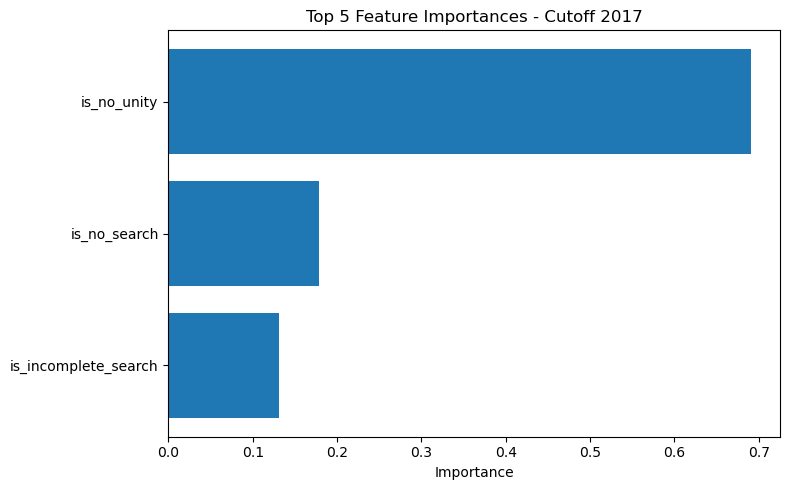

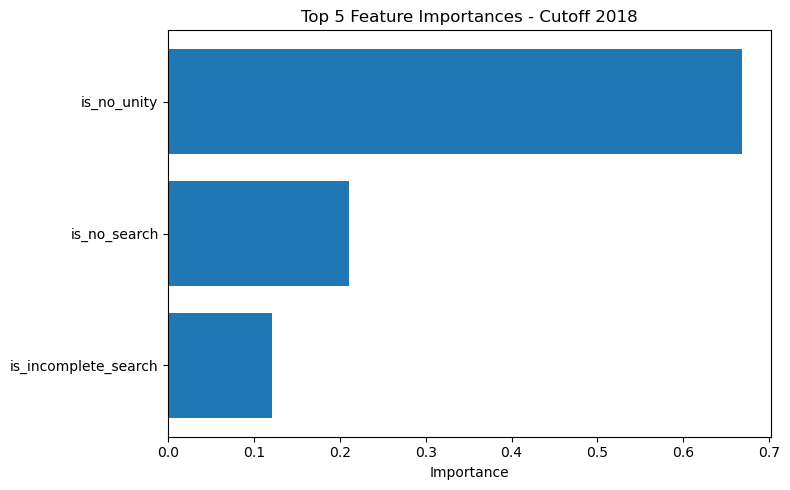

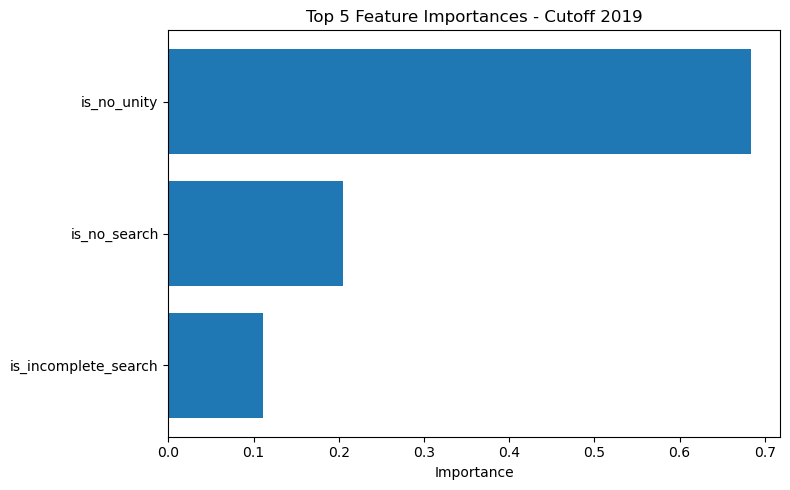

In [61]:
basic_dropped_data_results = split_train_test_by_cutoff_years(
    df=basic_dropped_df,
    model=DecisionTreeClassifier(),
    target_col=target_col,
    feature_cols=feature_cols
)

plot_metrics_and_feature_importances(basic_patent_data_results)

Best F1 score at cutoff year: 2015
Plotting SHAP summary for XGBoost...


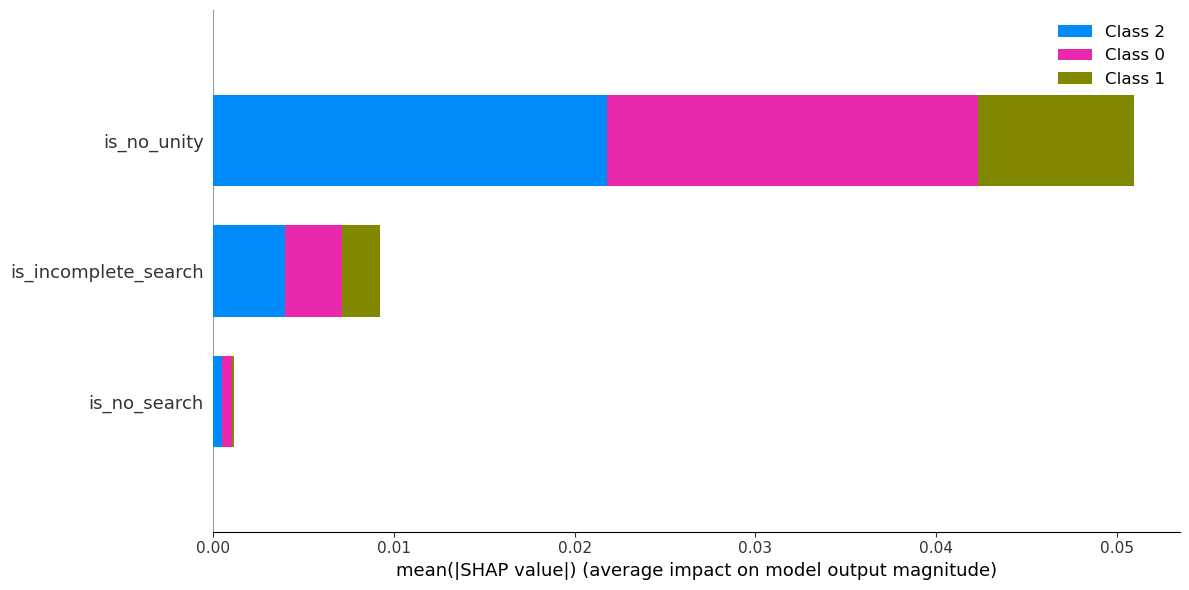

In [62]:
model, explainer, shap_values,label_mapping = shap_summary_best_f1_xgboost(
    results=basic_dropped_data_results,
    df=basic_dropped_df,
    target_col='application_status_target',  # adjust this if your label column is different
    feature_exclude_cols=['publication_date', 'application_number', 'value_imputed']
)


# Claims tree basic characteristics added data

In [15]:
claims_tree_data = pd.read_csv('./Data/tree_derived_basic_characteristics_app_num.csv',sep='\t',low_memory=False)

In [16]:
dropped_columns_for_joining = [item for item in dropped_collumns_for_classification  if item != 'application_number']

In [17]:
basic_patent_data_for_joining = basic_patent_data.drop(columns = dropped_columns_for_joining)

In [18]:
basic_patent_data_for_joining.columns

Index(['application_number', 'is_no_unity', 'is_incomplete_search',
       'is_no_search', 'publication_date', 'value_imputed',
       'application_status_target'],
      dtype='object')

In [74]:
# Perform an inner join on 'application_number'
claims_tree_added_data_for_further_join = pd.merge(
    basic_patent_data_for_joining,
    claims_tree_data,
    on='application_number',
    how='inner'
)

claims_tree_added_data = claims_tree_added_data_for_further_join.drop(columns =['application_number','total_claims_tree'])


In [20]:
claims_tree_added_data.columns

Index(['is_no_unity', 'is_incomplete_search', 'is_no_search',
       'publication_date', 'value_imputed', 'application_status_target',
       'num_claims', 'num_independent_claims_tree',
       'ratio_dep_to_total_claims_tree', 'max_depth_tree',
       'average_depth_tree', 'avg_branching_factor_tree',
       'max_branching_factor_tree'],
      dtype='object')

In [66]:
feature_cols = ['is_no_unity', 'is_incomplete_search', 'is_no_search',
       'num_claims', 'num_independent_claims_tree',
       'ratio_dep_to_total_claims_tree', 'max_depth_tree',
       'average_depth_tree', 'avg_branching_factor_tree',
       'max_branching_factor_tree']

target_col = 'application_status_target'

## No imputed values dropped

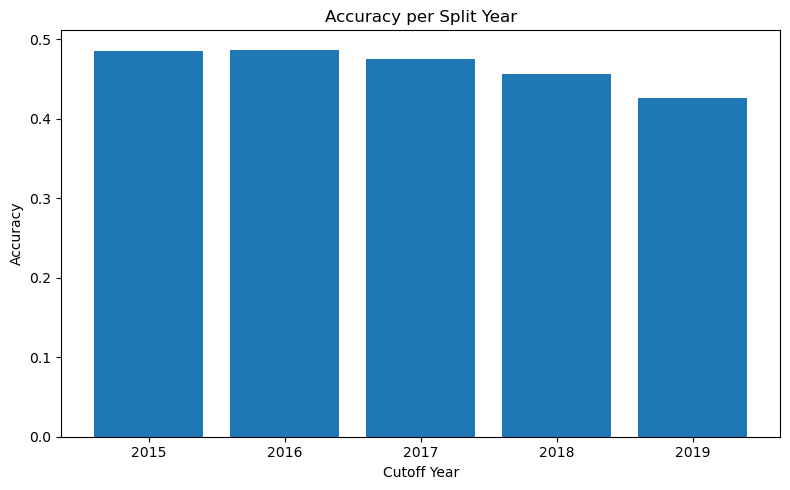

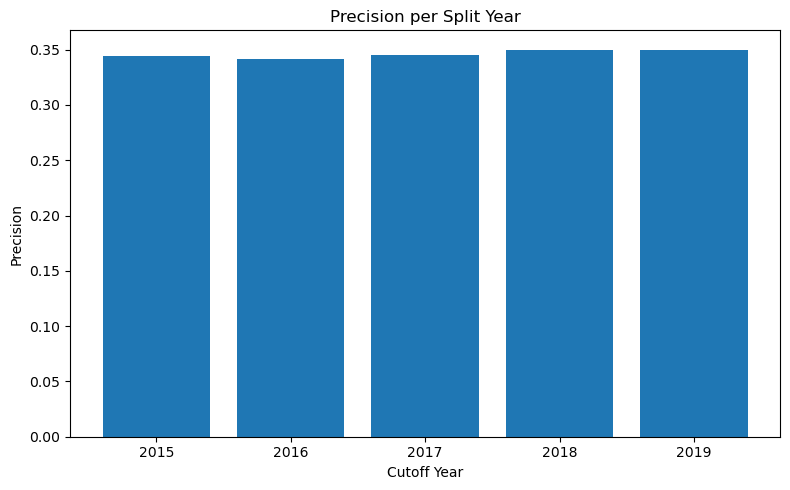

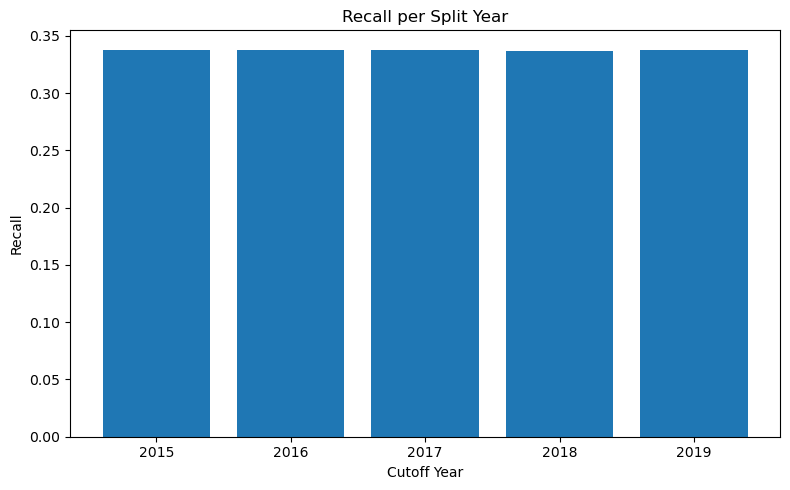

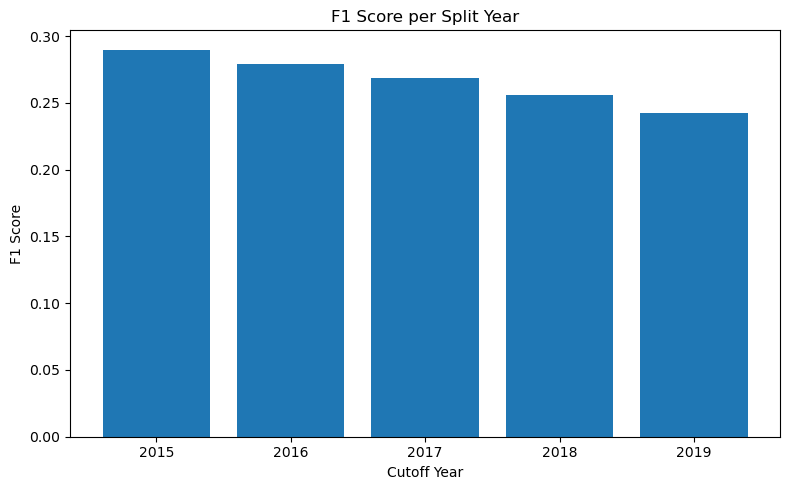

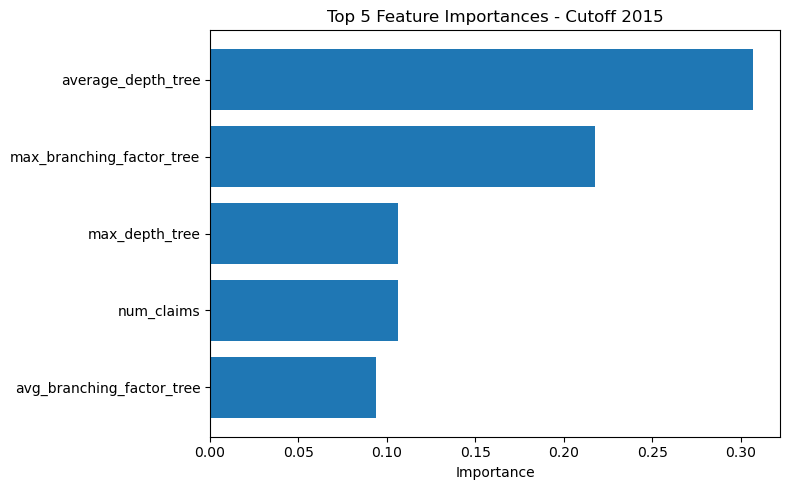

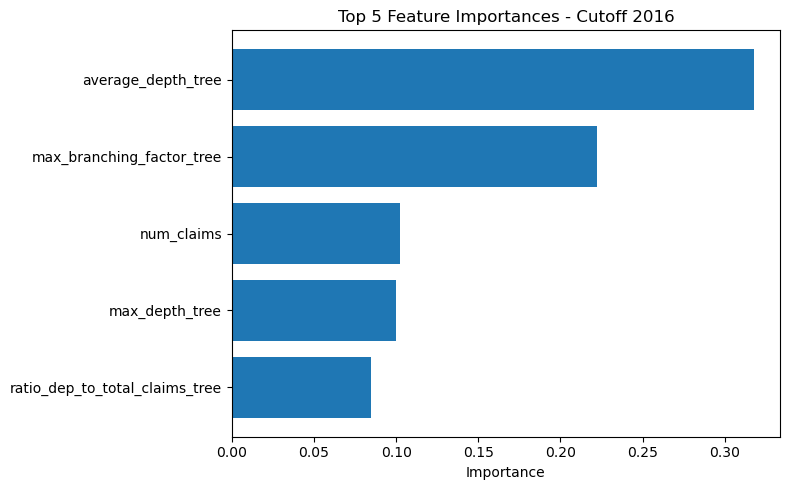

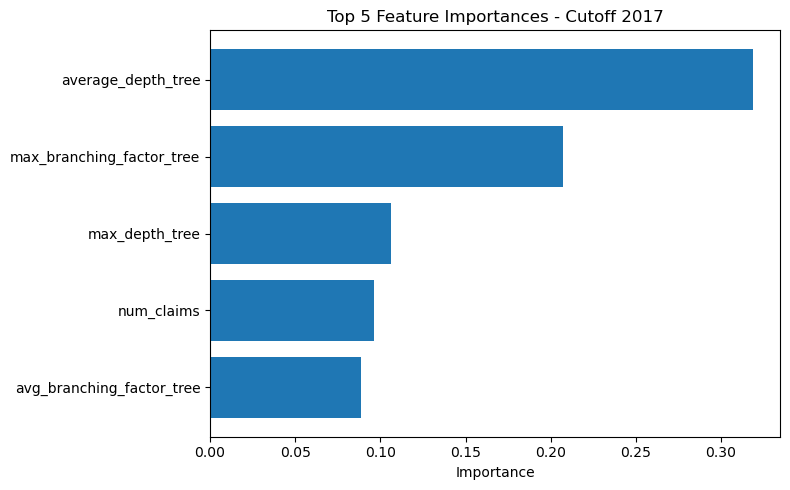

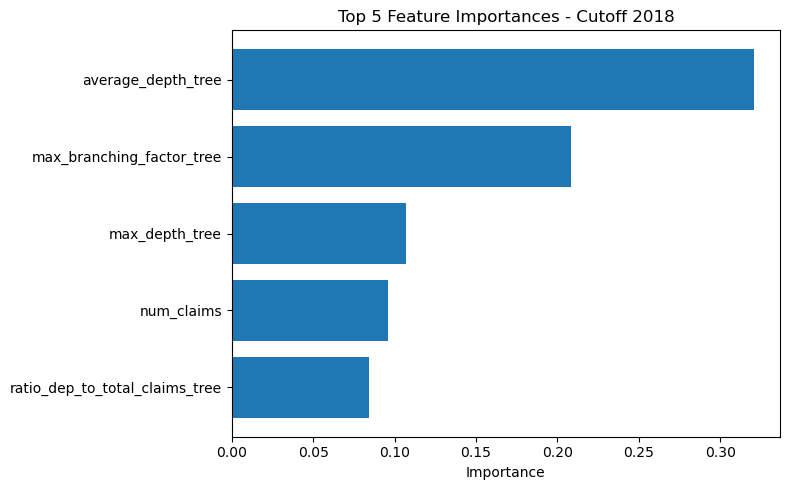

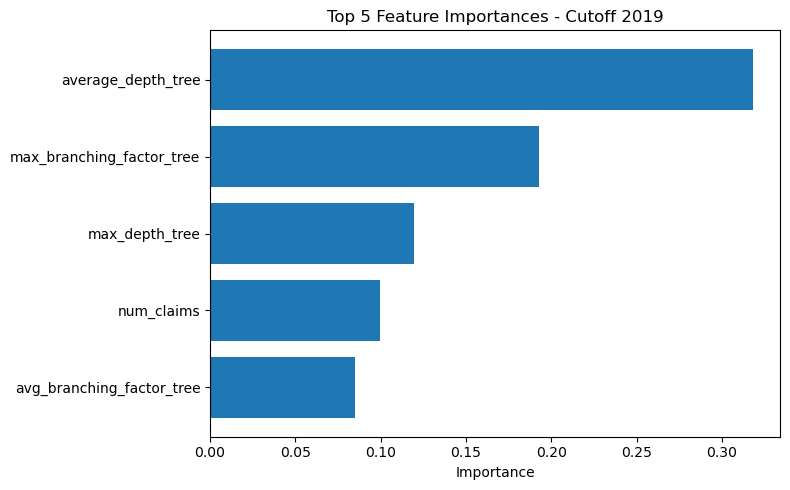

In [22]:
claim_tree_data_results = split_train_test_by_cutoff_years(
    df=claims_tree_added_data,
    model=DecisionTreeClassifier(),
    target_col=target_col,
    feature_cols=feature_cols
)

plot_metrics_and_feature_importances(claim_tree_data_results)

Best F1 score at cutoff year: 2015
Plotting SHAP summary for XGBoost...


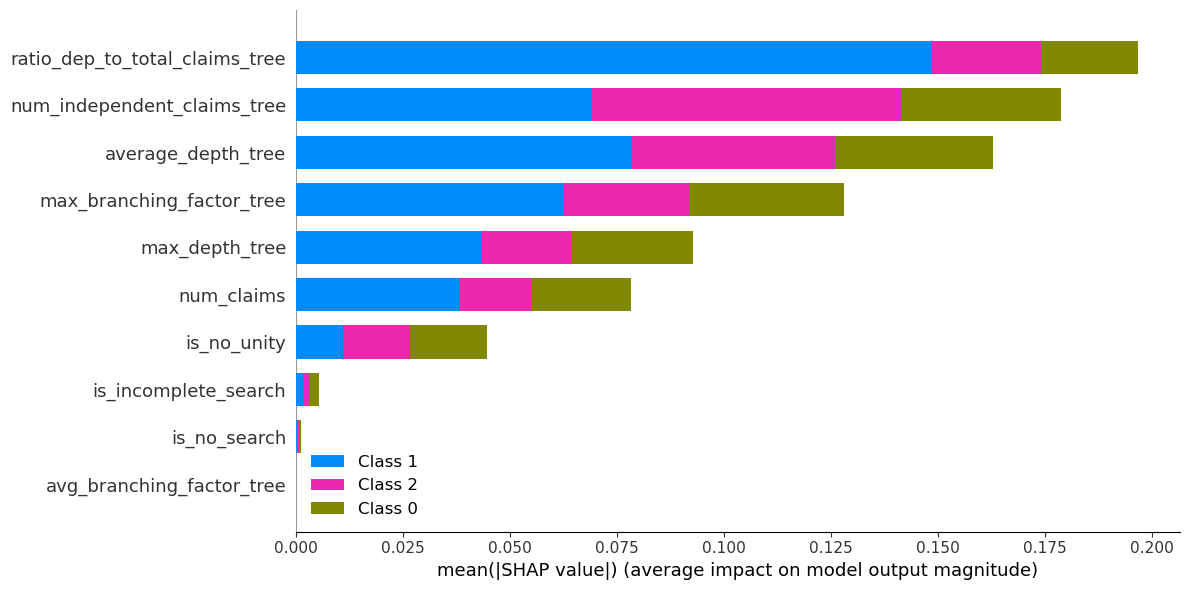

In [57]:
model, explainer, shap_values,label_mapping = shap_summary_best_f1_xgboost(
    results=claim_tree_data_results,
    df=claims_tree_added_data,
    target_col='application_status_target',  # adjust this if your label column is different
    feature_exclude_cols=['publication_date', 'application_number', 'value_imputed']
)

## Imputed Values dropped

In [64]:
imputed_dropped_claim_tree_data = claims_tree_added_data[claims_tree_added_data['value_imputed']==False]

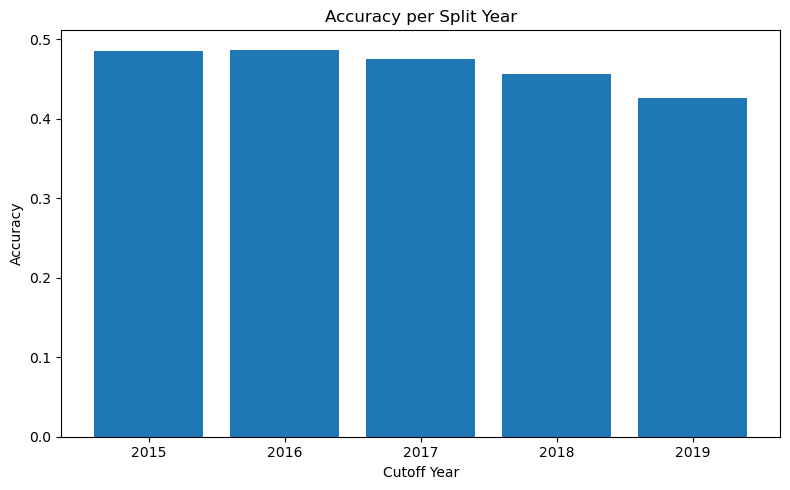

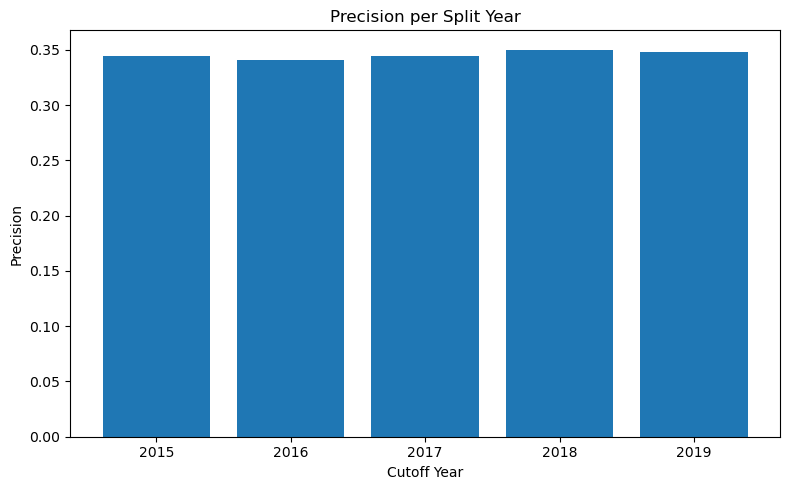

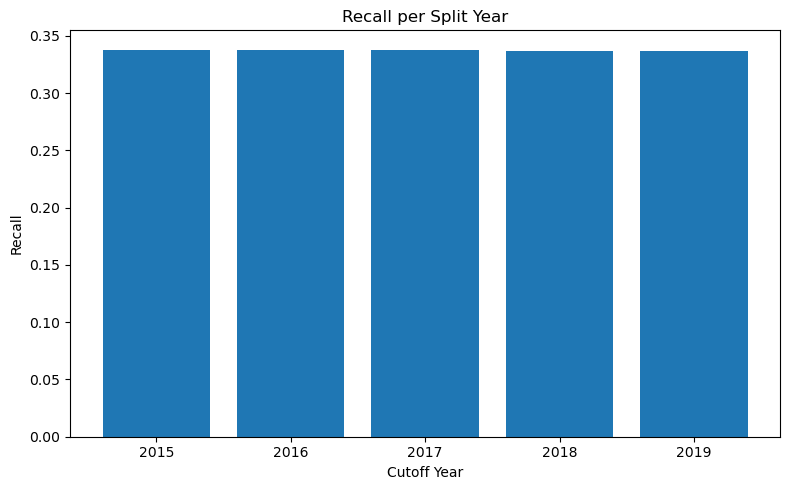

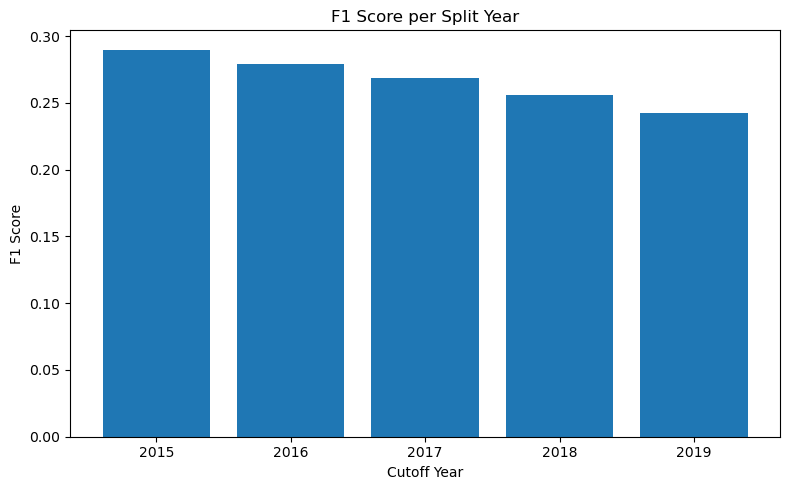

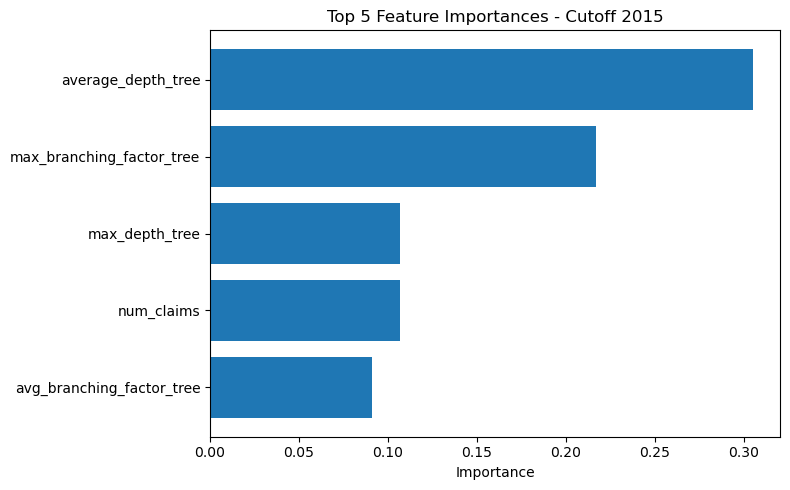

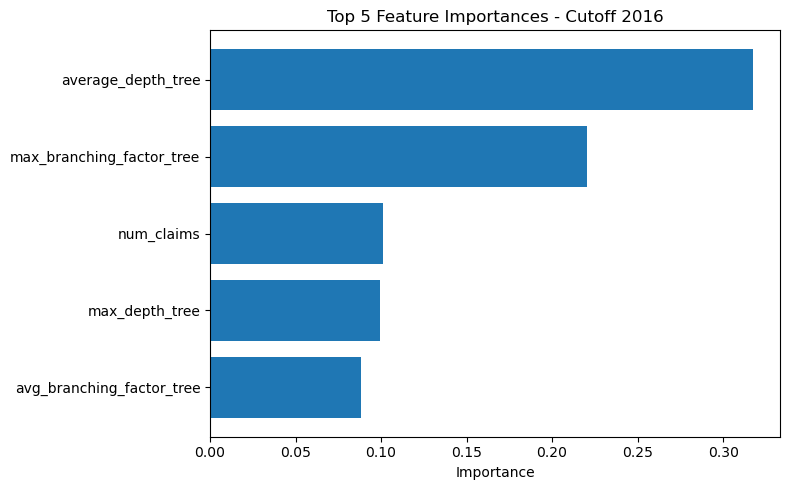

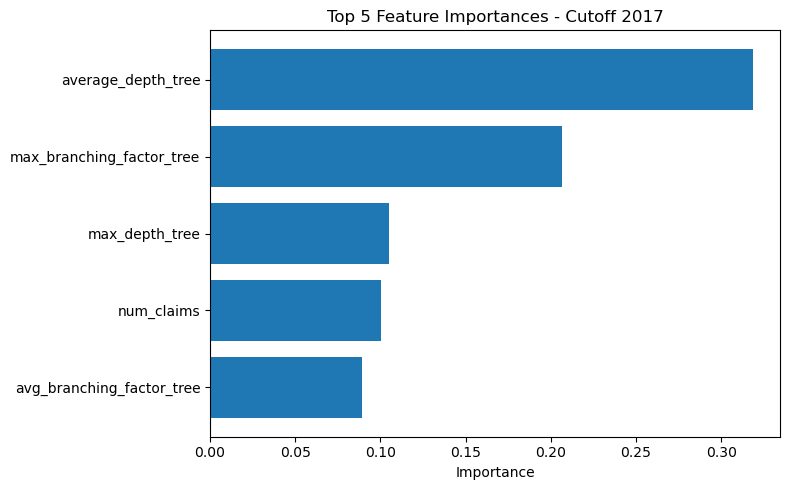

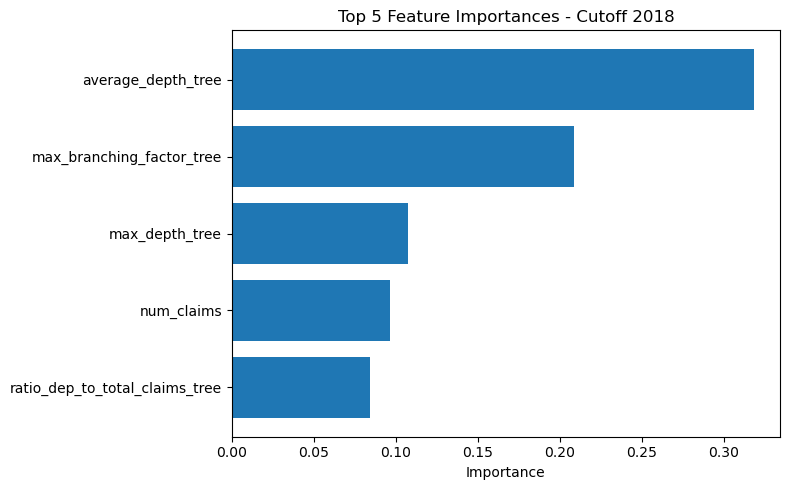

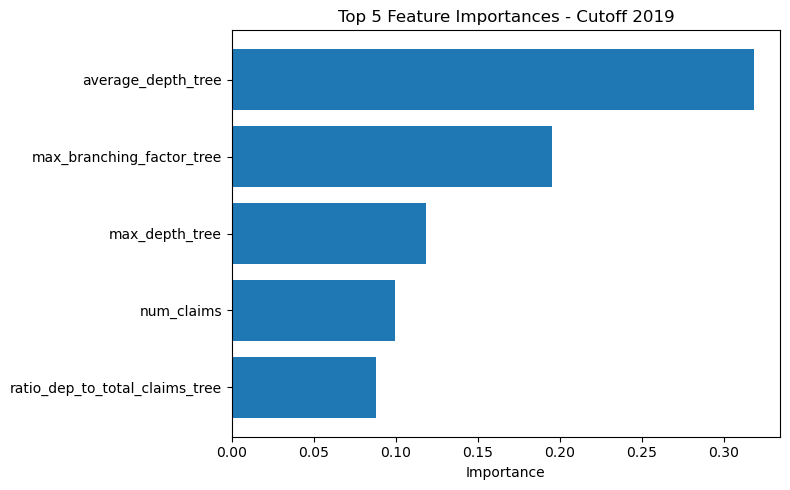

In [67]:
claim_tree_data_imputed_dropped_results = split_train_test_by_cutoff_years(
    df=imputed_dropped_claim_tree_data,
    model=DecisionTreeClassifier(),
    target_col=target_col,
    feature_cols=feature_cols
)

plot_metrics_and_feature_importances(claim_tree_data_imputed_dropped_results)

# SREP data added

In [68]:
srep_data = pd.read_csv('./Data/srep_citation_reference_derived_data.csv',sep='\t',low_memory=False)

In [76]:
srep_data_for_further_join = pd.merge(
    srep_data,
    claims_tree_added_data_for_further_join,
    on='application_number',
    how='inner'
)


srep_data_joined = srep_data_for_further_join.drop(columns =['application_number','total_claims_tree'])

In [86]:
left_out_cols = ['value_imputed', 'application_status_target','publication_date']
feature_cols = [item for item in list(srep_data_joined.columns) if item not in left_out_cols]
target_col = 'application_status_target'

## No imputed values dropped

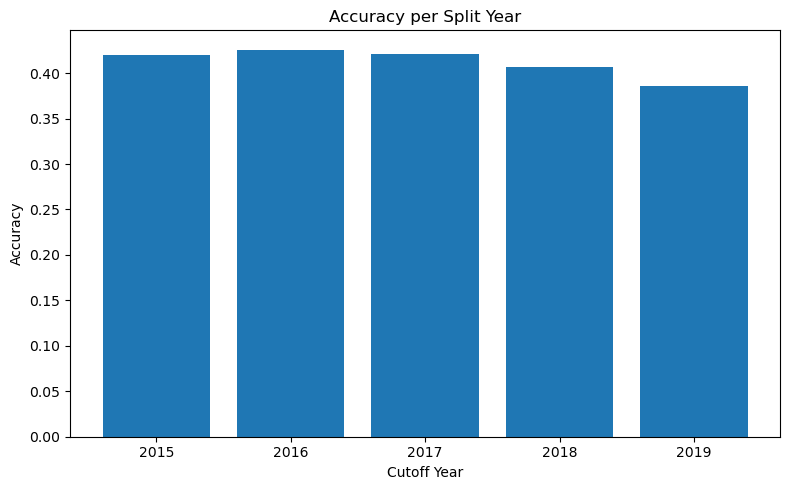

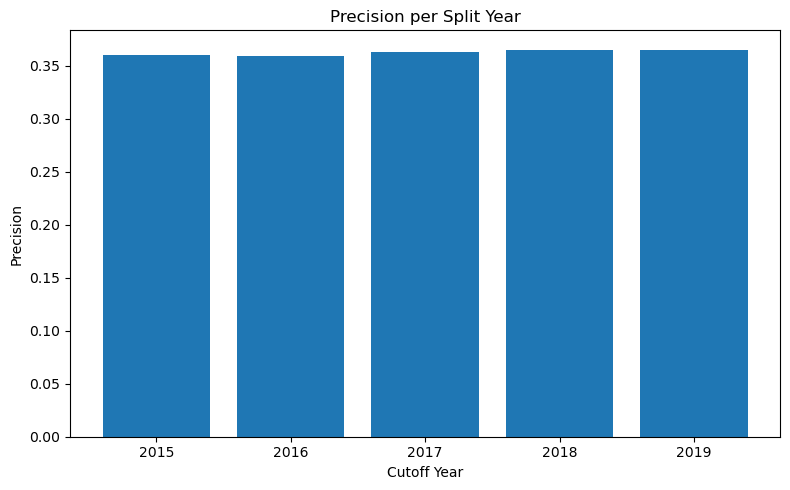

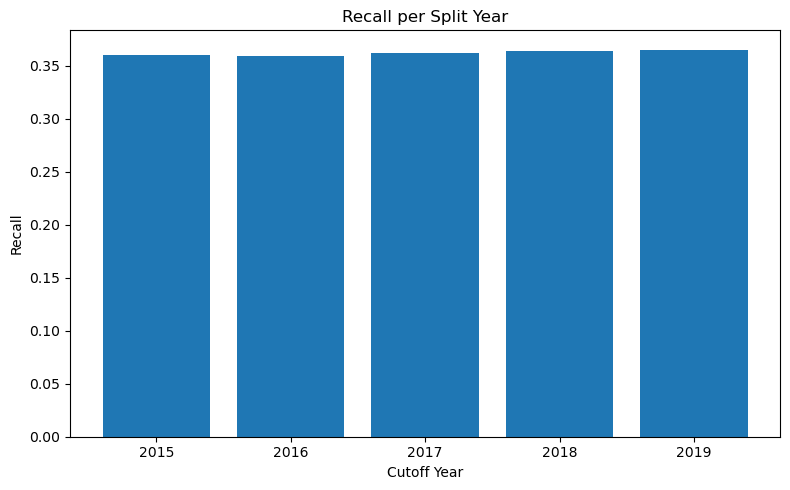

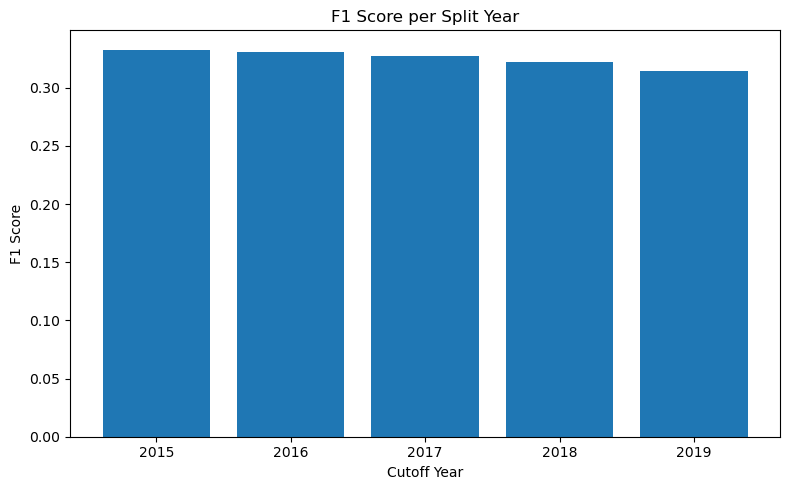

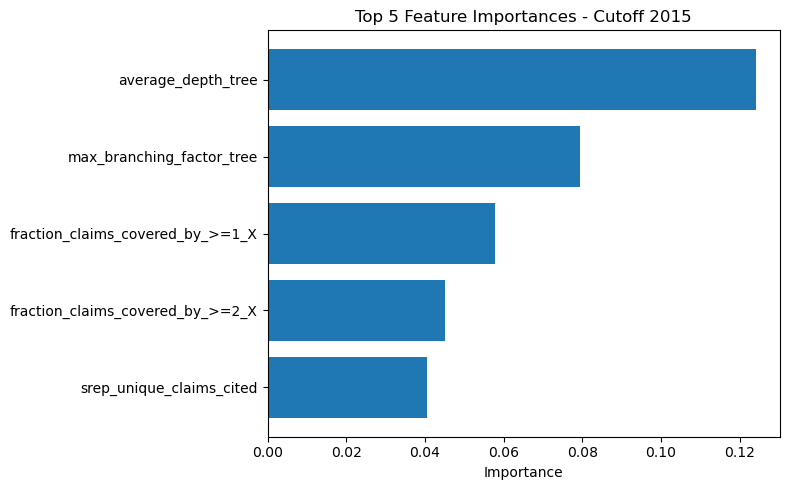

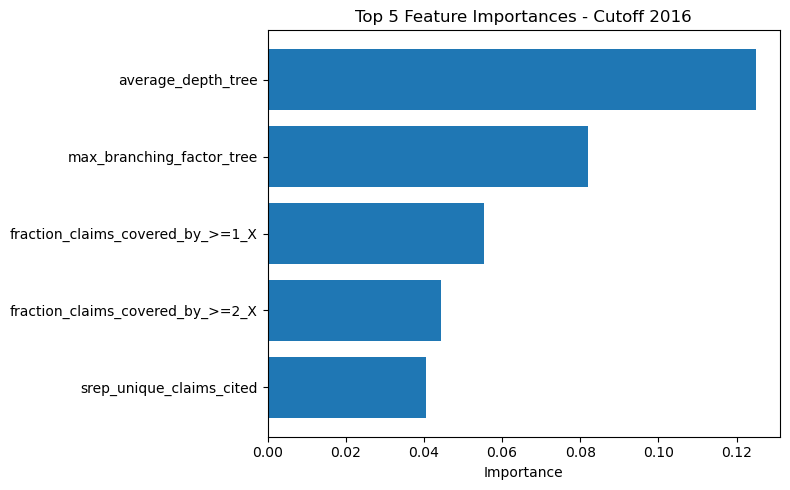

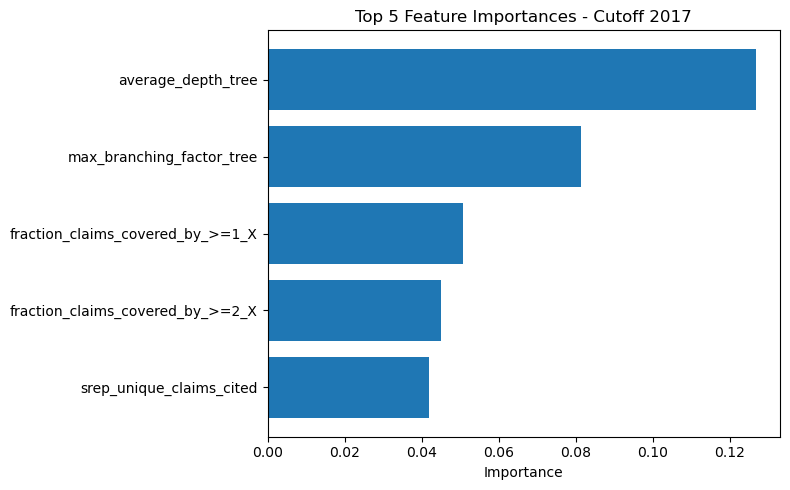

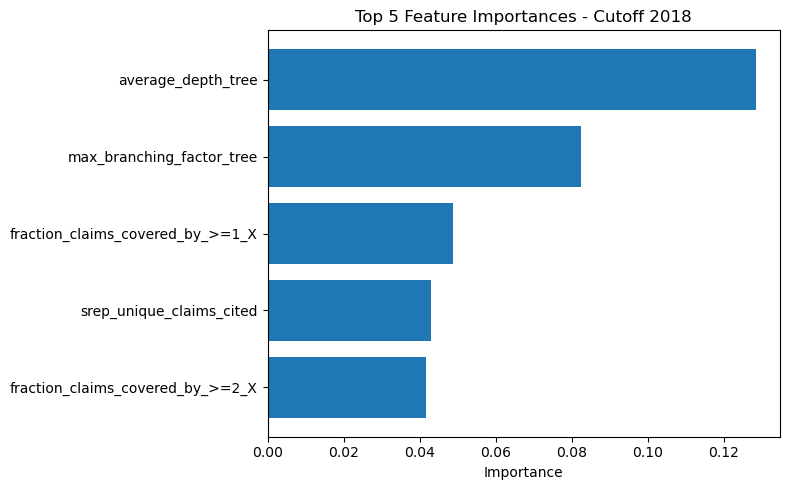

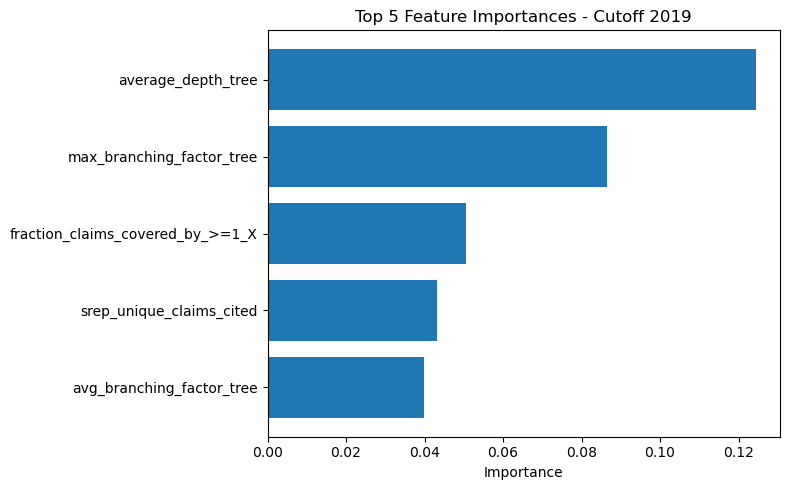

In [87]:
srep_data_results = split_train_test_by_cutoff_years(
    df=srep_data_joined,
    model=DecisionTreeClassifier(),
    target_col=target_col,
    feature_cols=feature_cols
)

plot_metrics_and_feature_importances(srep_data_results)

Best F1 score at cutoff year: 2015
SHAP values shape: (300, 51, 3)


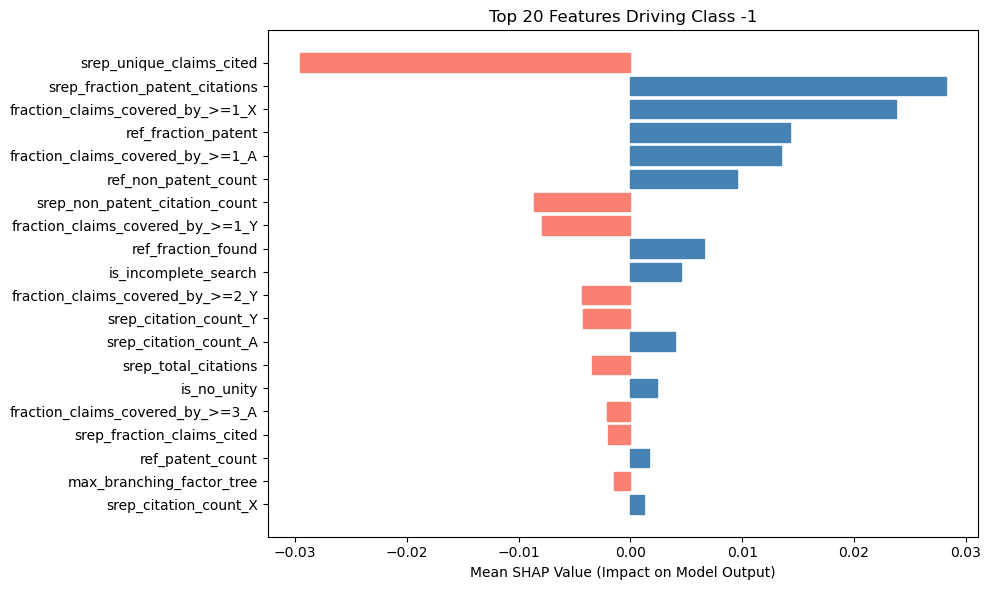

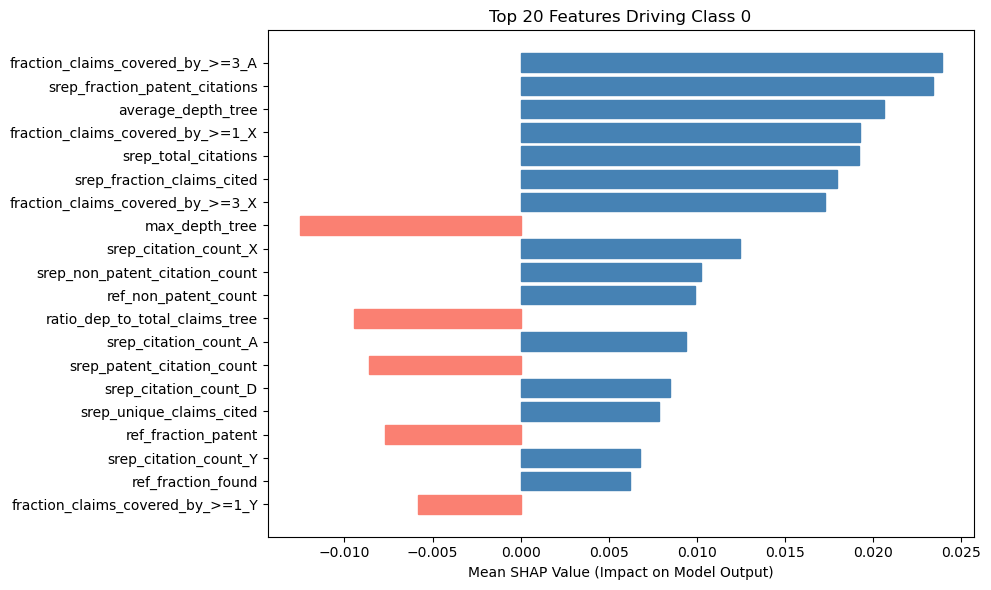

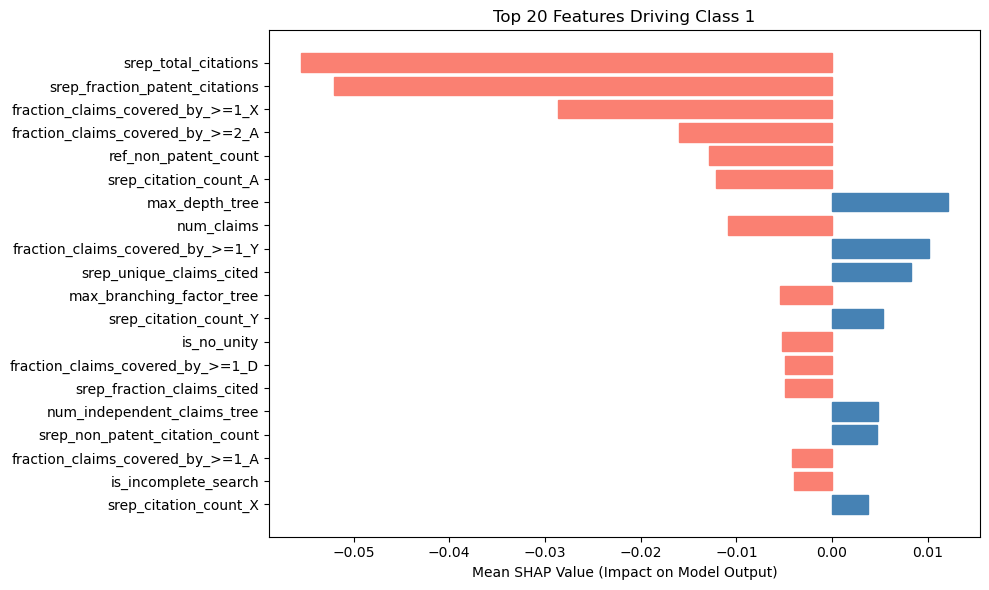

In [127]:
model, explainer, shap_values,label_mapping = shap_summary_best_f1_xgboost(
    results=srep_data_results,
    df=srep_data_joined,
    target_col='application_status_target',  # adjust this if your label column is different
    feature_exclude_cols=['publication_date', 'application_number', 'value_imputed']
)

## Imputed values dropped

In [136]:
srep_data_joined_imputed_dropped = srep_data_joined[srep_data_joined['value_imputed']==False]

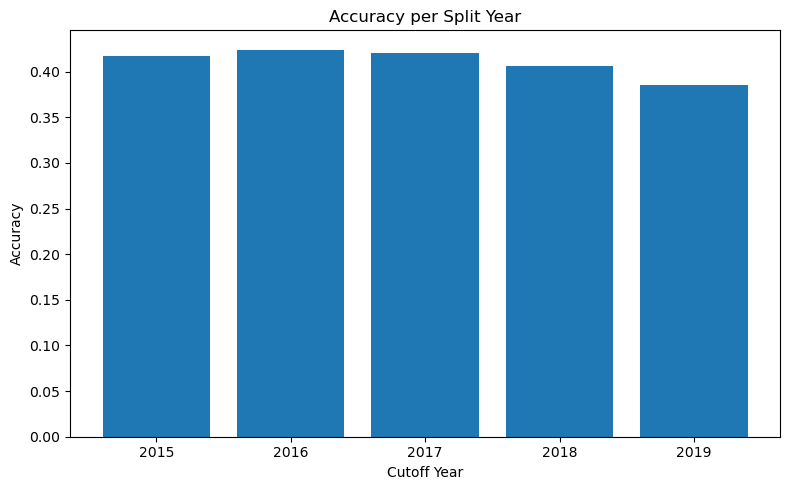

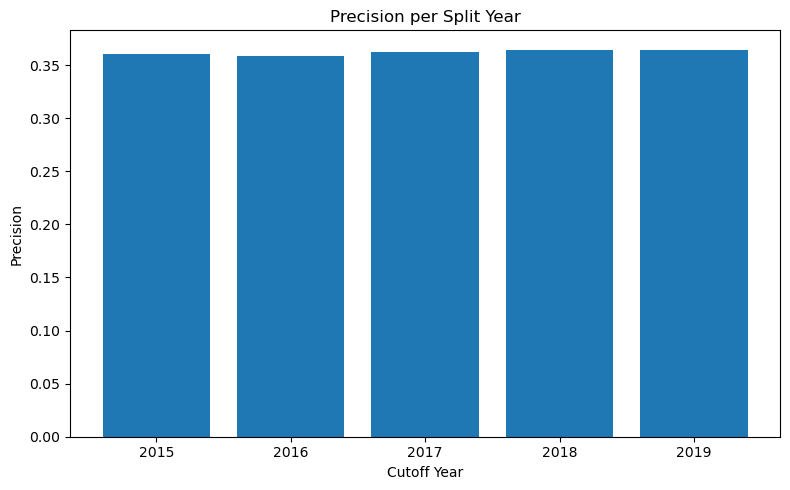

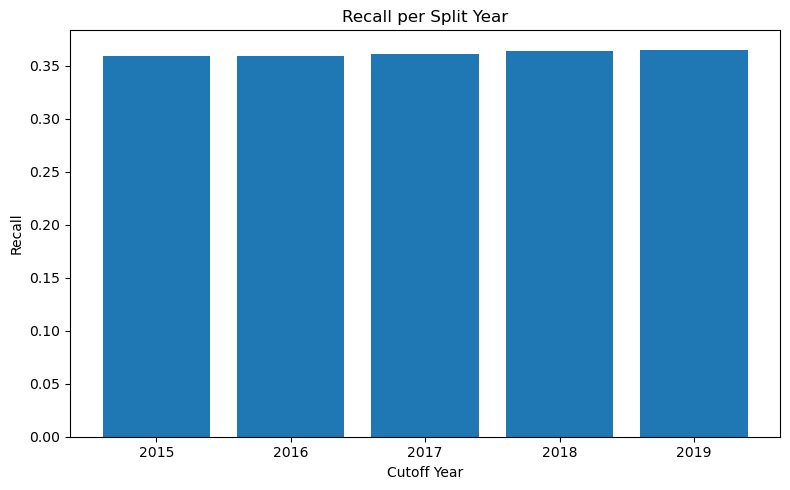

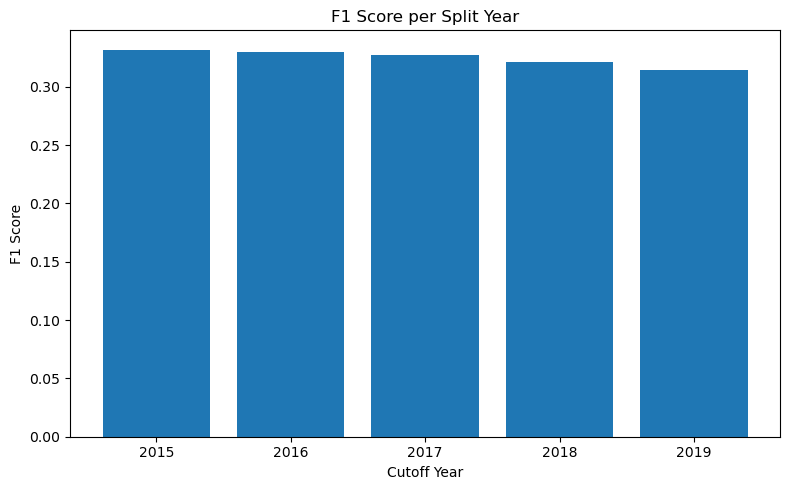

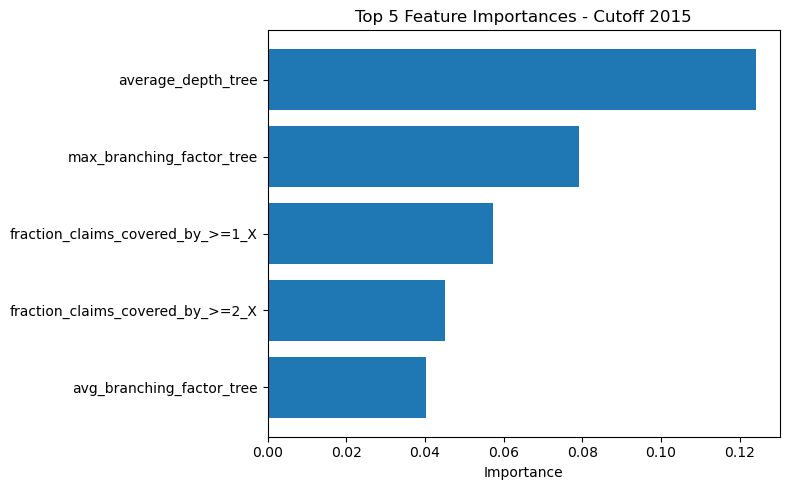

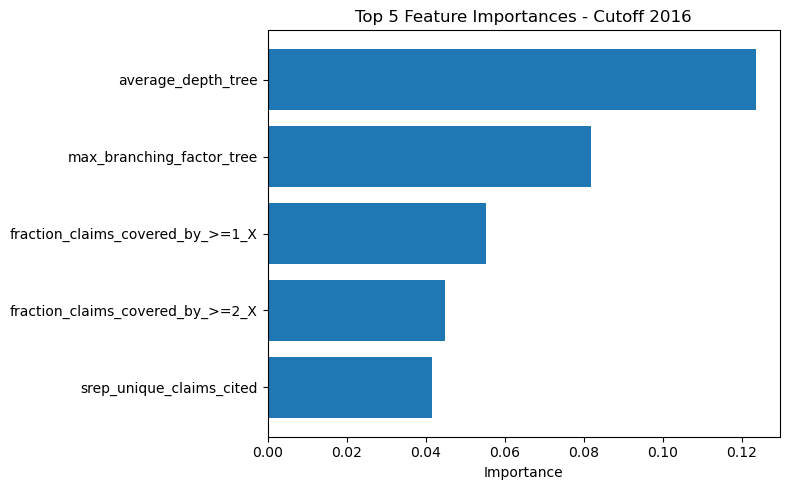

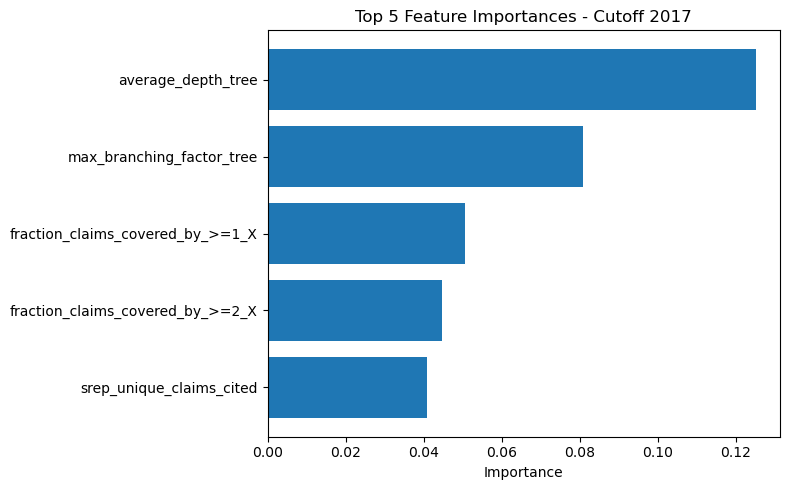

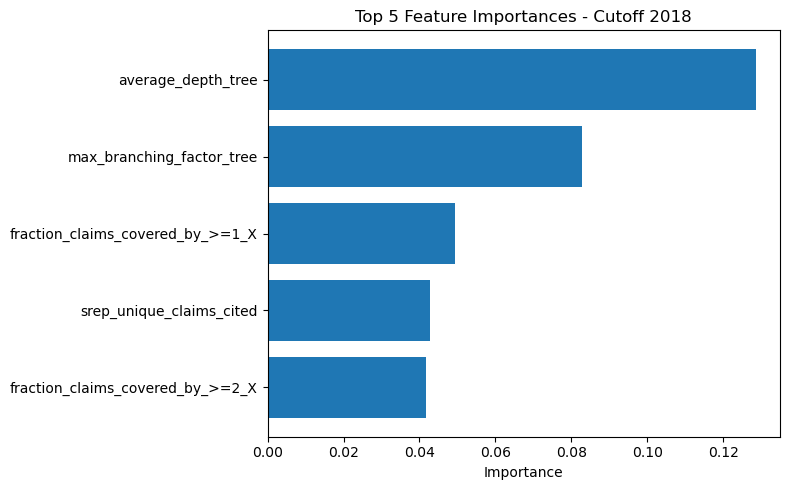

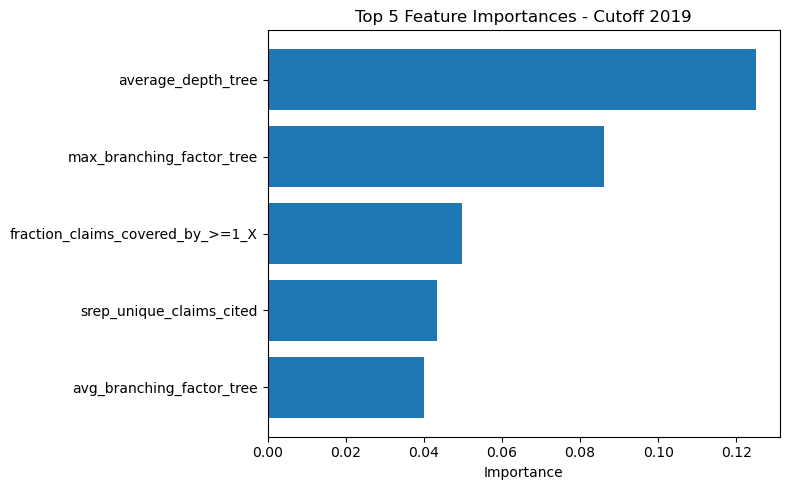

In [140]:
srep_data_joined_imputed_dropped_results = split_train_test_by_cutoff_years(
    df=srep_data_joined_imputed_dropped,
    model=DecisionTreeClassifier(),
    target_col=target_col,
    feature_cols=feature_cols
)

plot_metrics_and_feature_importances(srep_data_joined_imputed_dropped_results)

Best F1 score at cutoff year: 2015
SHAP values shape: (300, 51, 3)


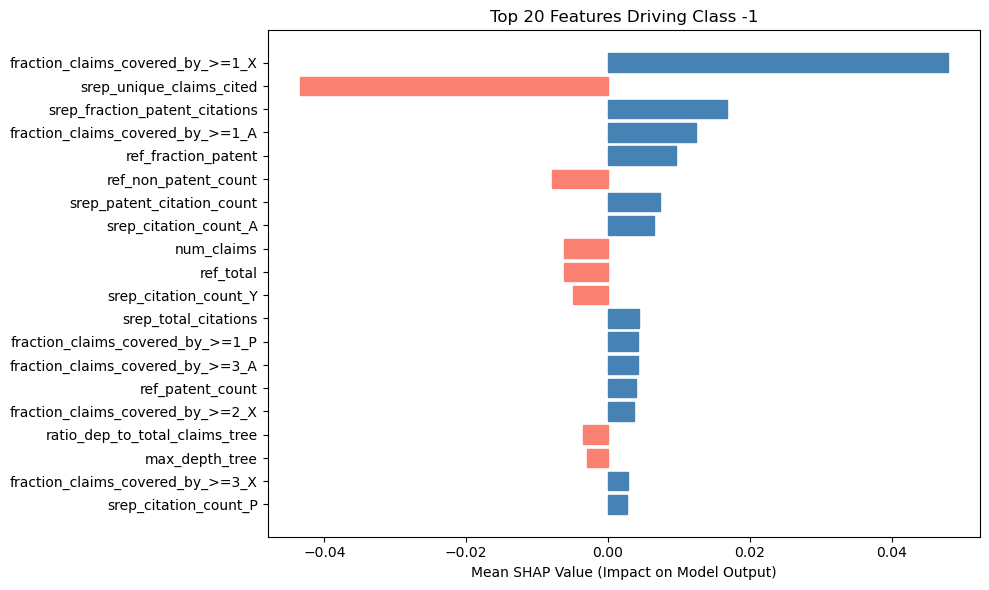

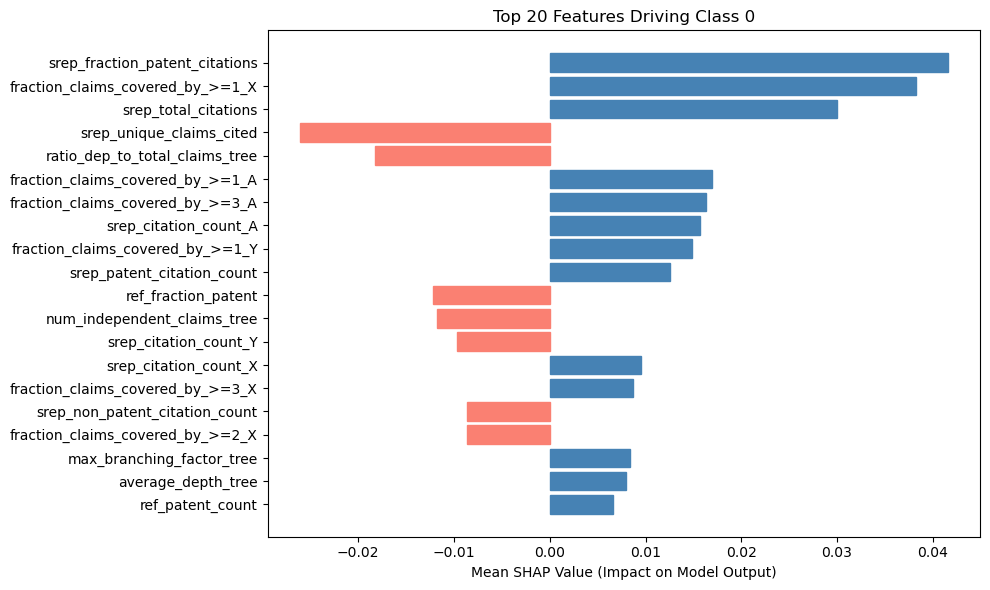

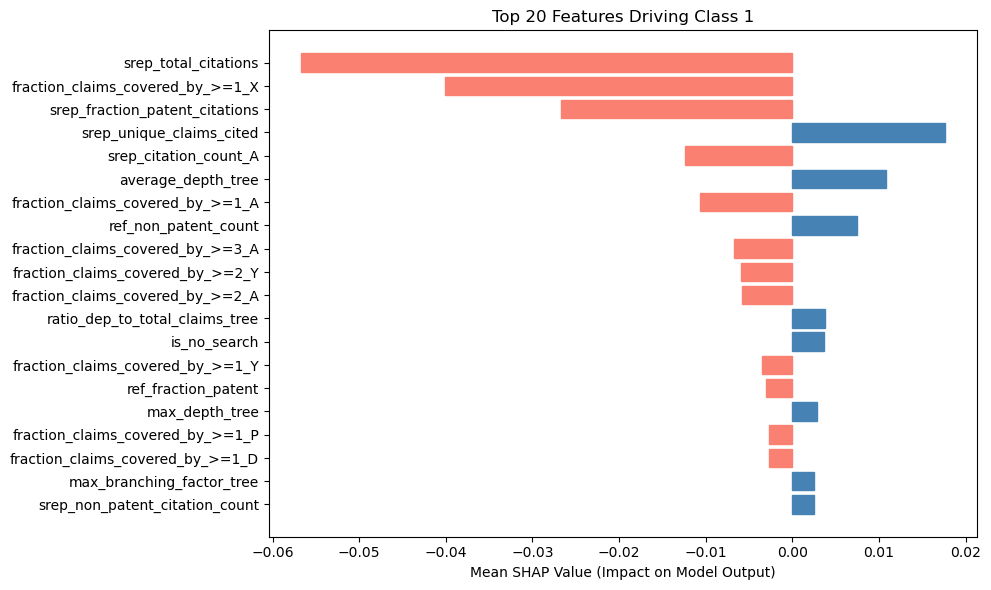

In [141]:
model, explainer, shap_values,label_mapping = shap_summary_best_f1_xgboost(
    results=srep_data_joined_imputed_dropped_results,
    df=srep_data_joined_imputed_dropped,
    target_col='application_status_target',  # adjust this if your label column is different
    feature_exclude_cols=['publication_date', 'application_number', 'value_imputed']
)

# Tree SREP metrics combined added

In [142]:
tree_srep_metrics_combined_data = pd.read_csv('./Data/tree_and_srep_citation_metrics_combined.csv',sep='\t',low_memory=False)

In [146]:
srep_tree_data_for_further_join = pd.merge(
    srep_data_for_further_join,
    tree_srep_metrics_combined_data,
    on='application_number',
    how='inner'
)


srep_tree_combined_data_joined = srep_tree_data_for_further_join.drop(columns =['application_number'])

In [152]:
left_out_cols = ['value_imputed', 'application_status_target','publication_date']
feature_cols = [item for item in list(srep_tree_combined_data_joined.columns) if item not in left_out_cols]
target_col = 'application_status_target'

## No imputed values dropped

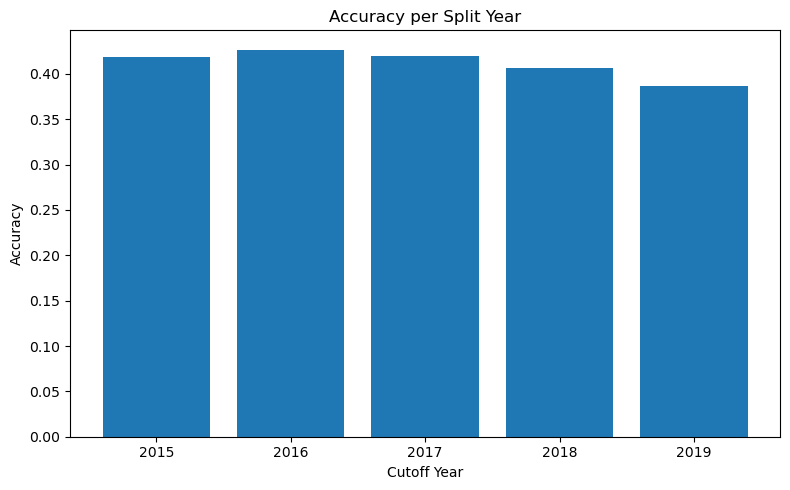

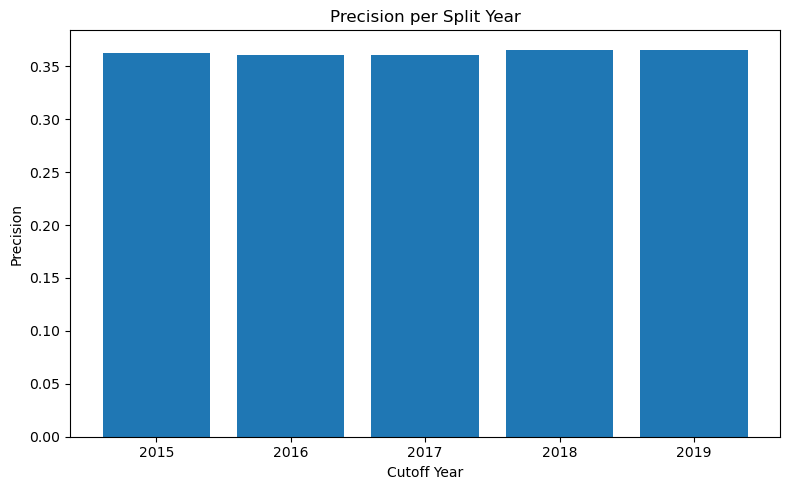

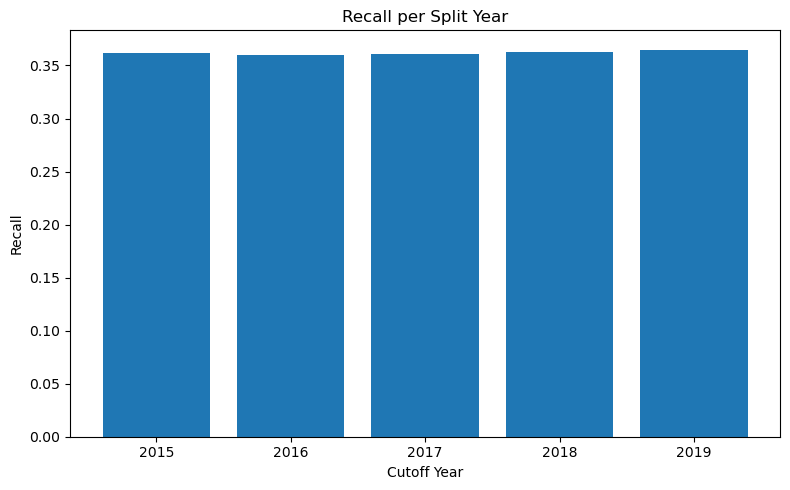

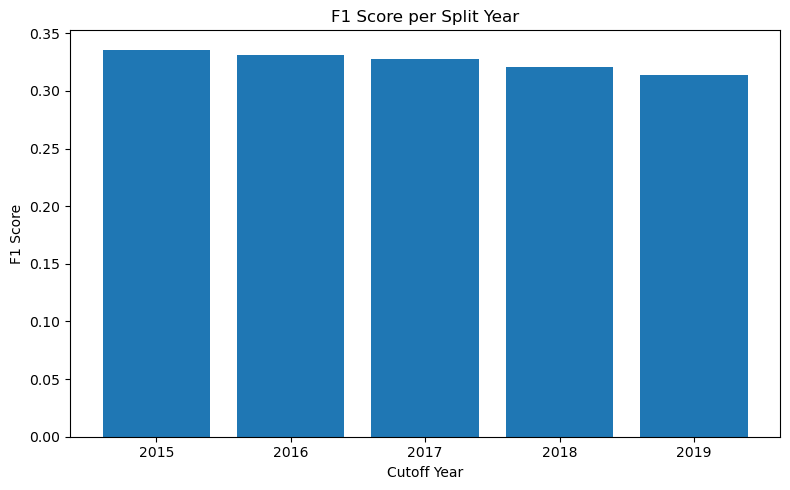

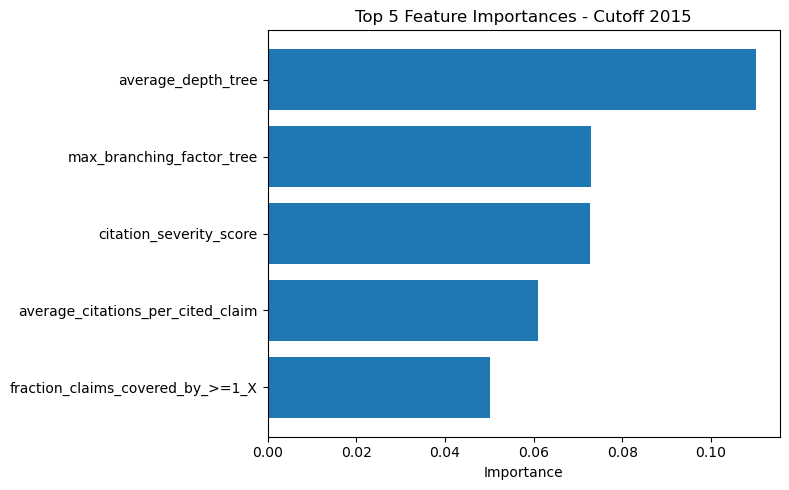

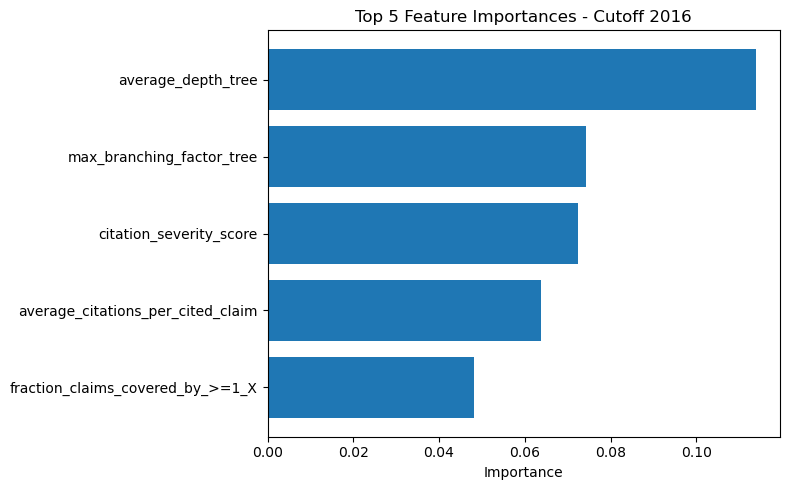

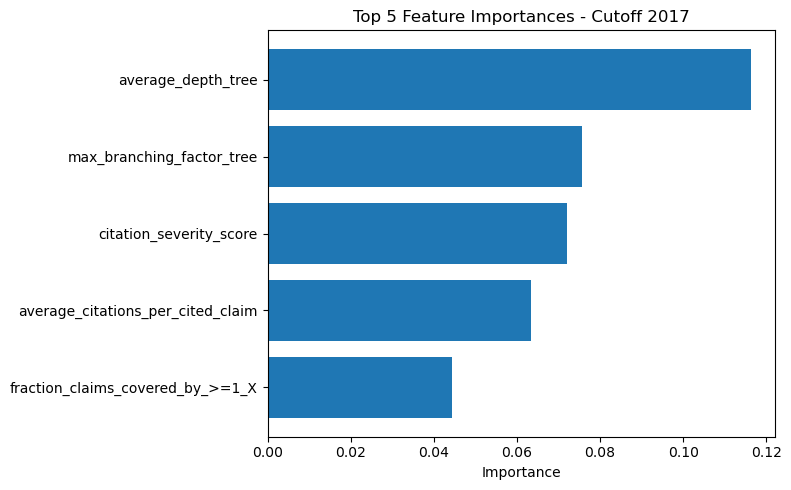

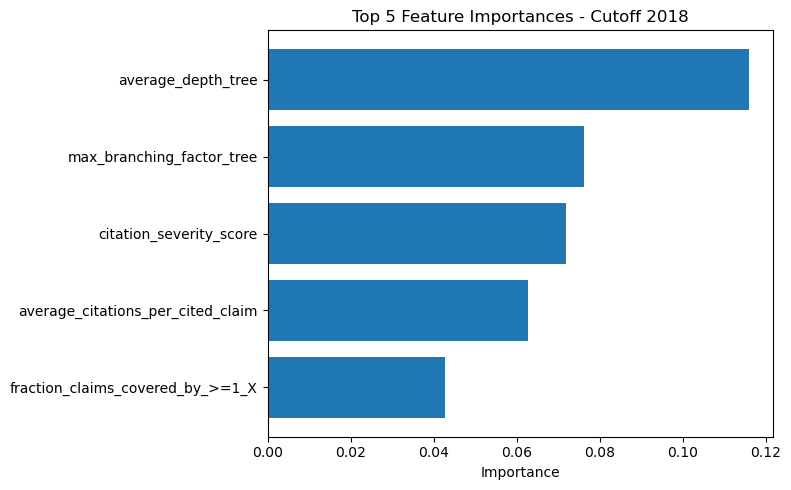

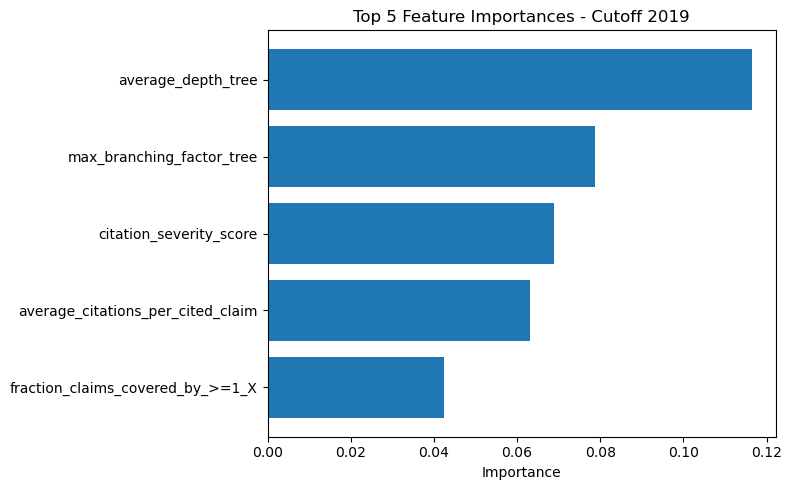

In [153]:
srep_tree_combined_data_results = split_train_test_by_cutoff_years(
    df=srep_tree_combined_data_joined,
    model=DecisionTreeClassifier(),
    target_col=target_col,
    feature_cols=feature_cols
)

plot_metrics_and_feature_importances(srep_tree_combined_data_results)

Best F1 score at cutoff year: 2015
SHAP values shape: (300, 59, 3)


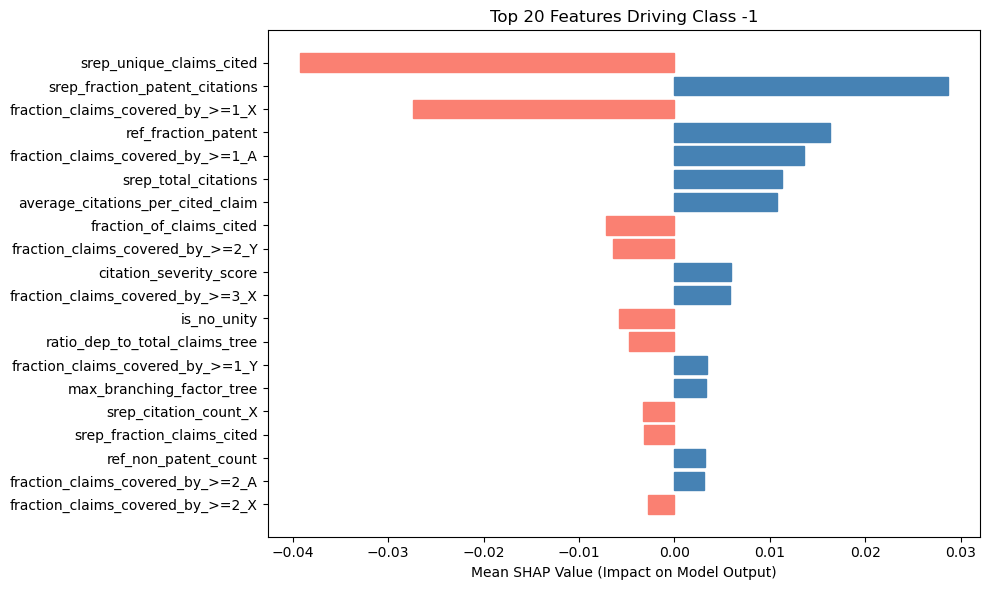

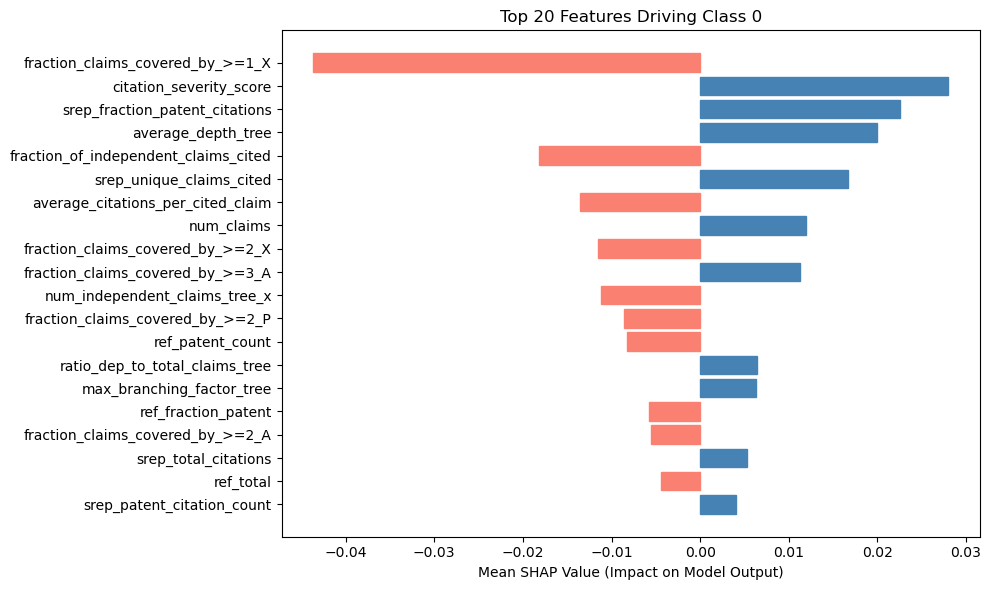

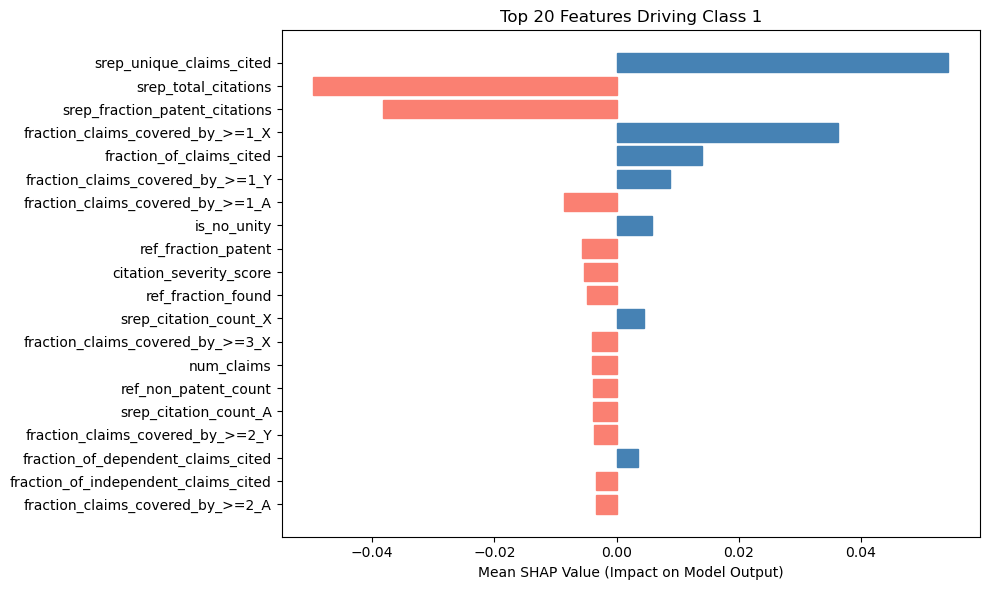

In [154]:
model, explainer, shap_values,label_mapping = shap_summary_best_f1_xgboost(
    results=srep_tree_combined_data_results,
    df=srep_tree_combined_data_joined,
    target_col='application_status_target',  # adjust this if your label column is different
    feature_exclude_cols=['publication_date', 'application_number', 'value_imputed']
)

## Imputed values dropped

In [155]:
srep_tree_combined_data_joined_dropped = srep_tree_combined_data_joined[srep_tree_combined_data_joined['value_imputed']==False]

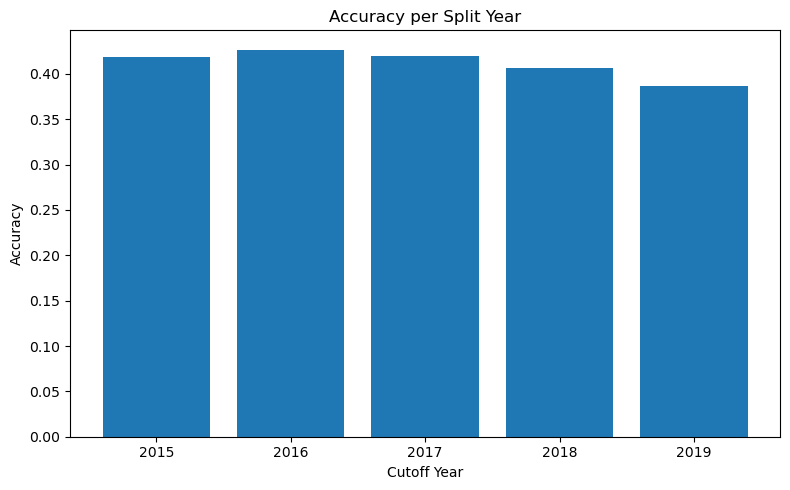

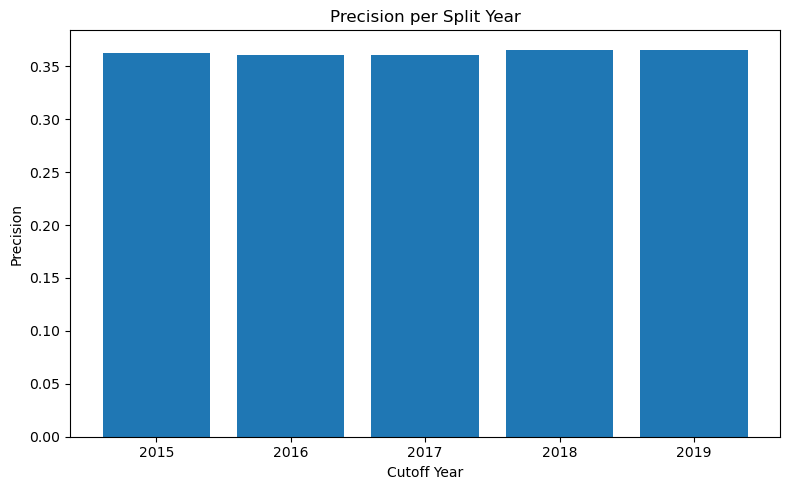

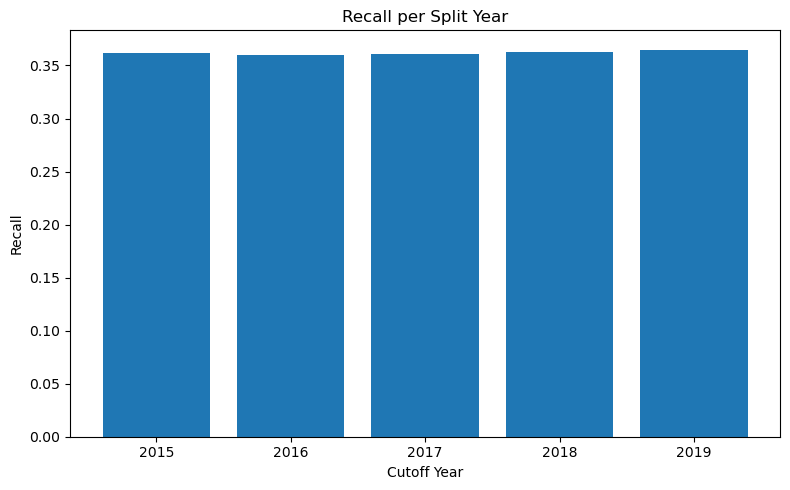

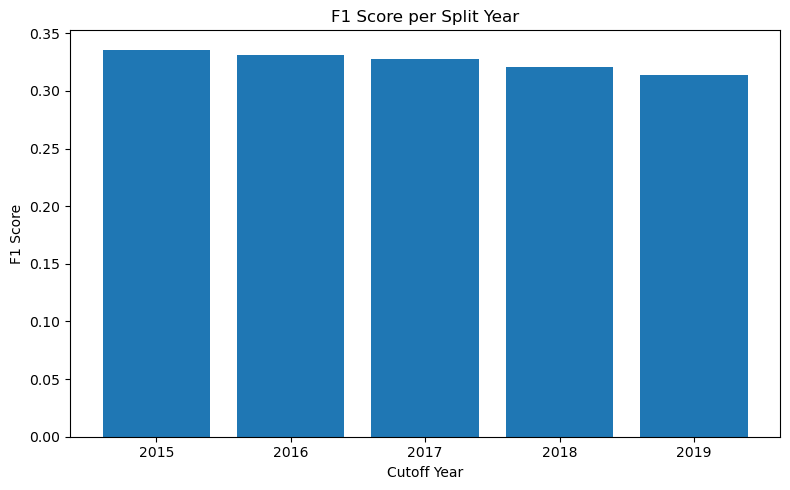

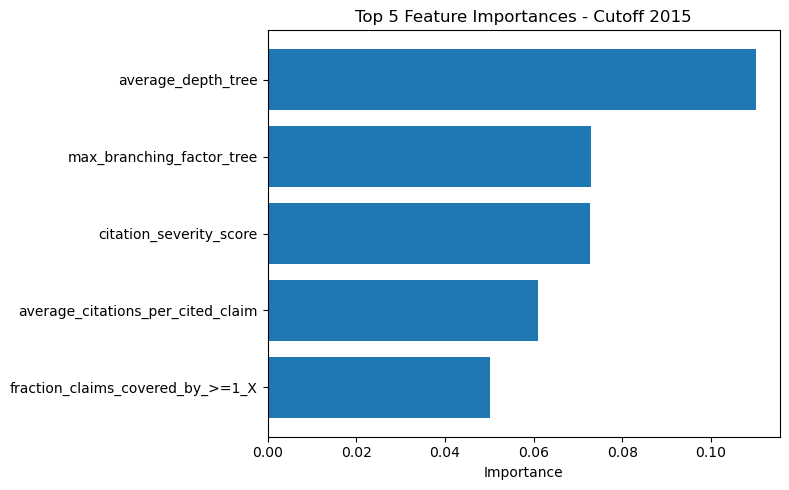

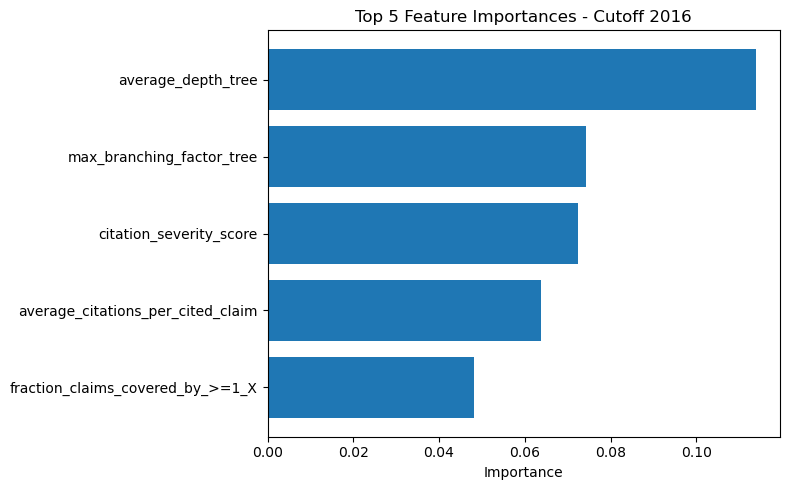

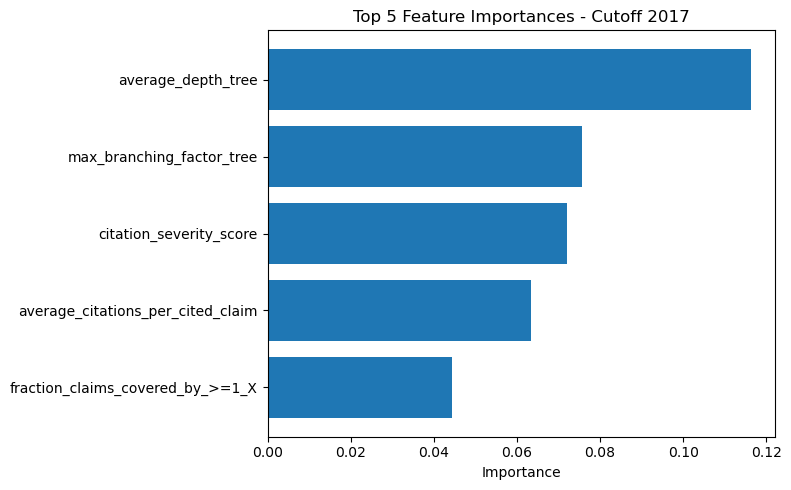

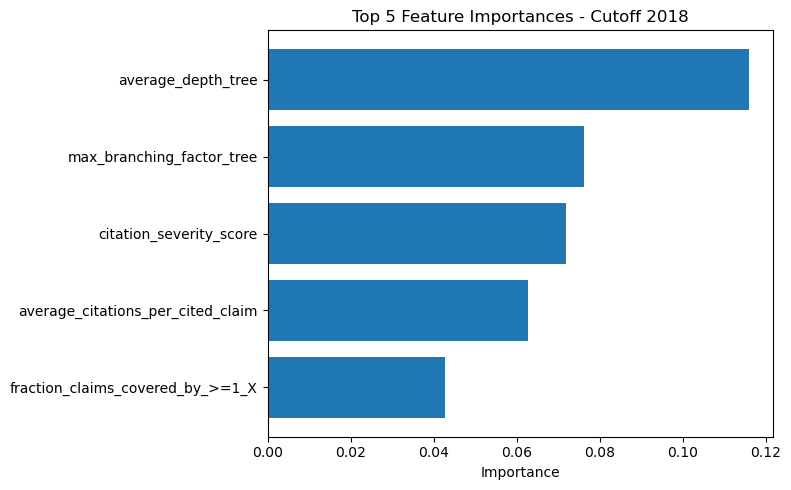

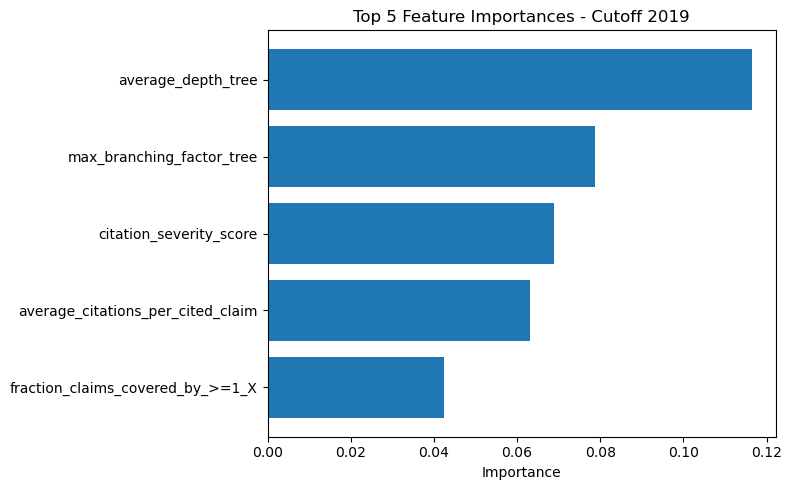

In [157]:
srep_tree_combined_data_results_dropped = split_train_test_by_cutoff_years(
    df=srep_tree_combined_data_joined_dropped,
    model=DecisionTreeClassifier(),
    target_col=target_col,
    feature_cols=feature_cols
)

plot_metrics_and_feature_importances(srep_tree_combined_data_results)

Best F1 score at cutoff year: 2015
SHAP values shape: (300, 59, 3)


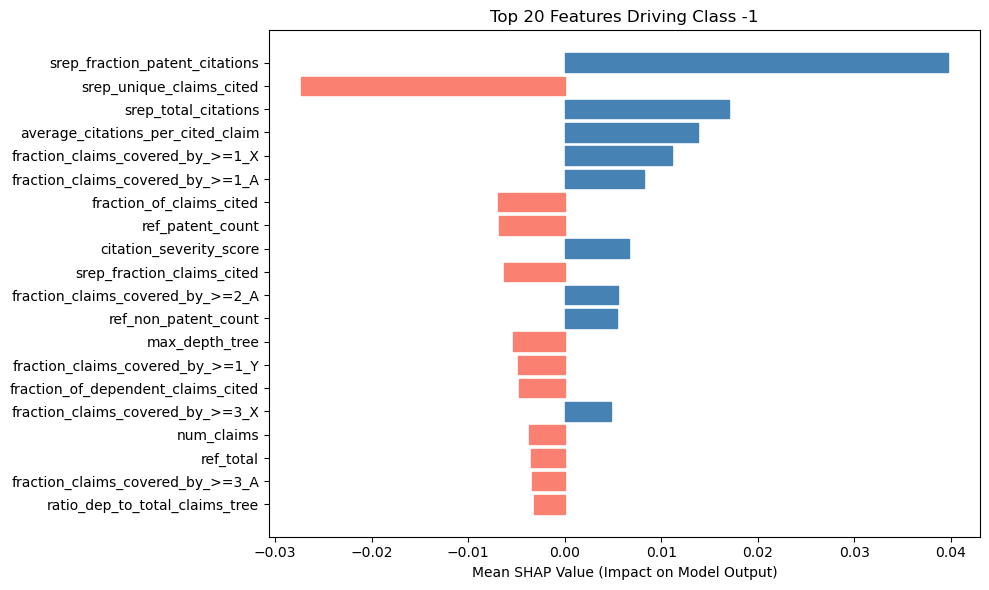

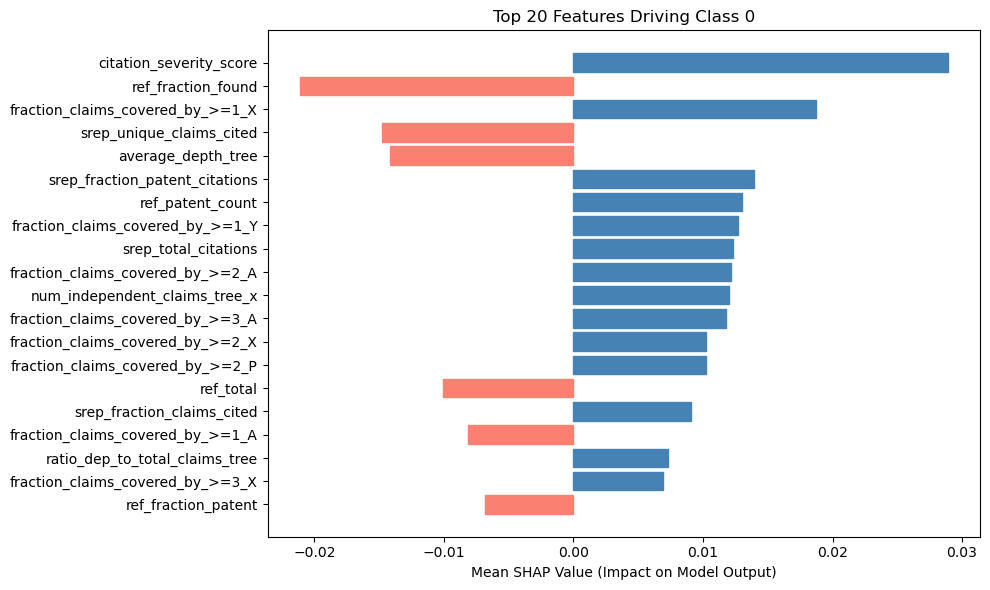

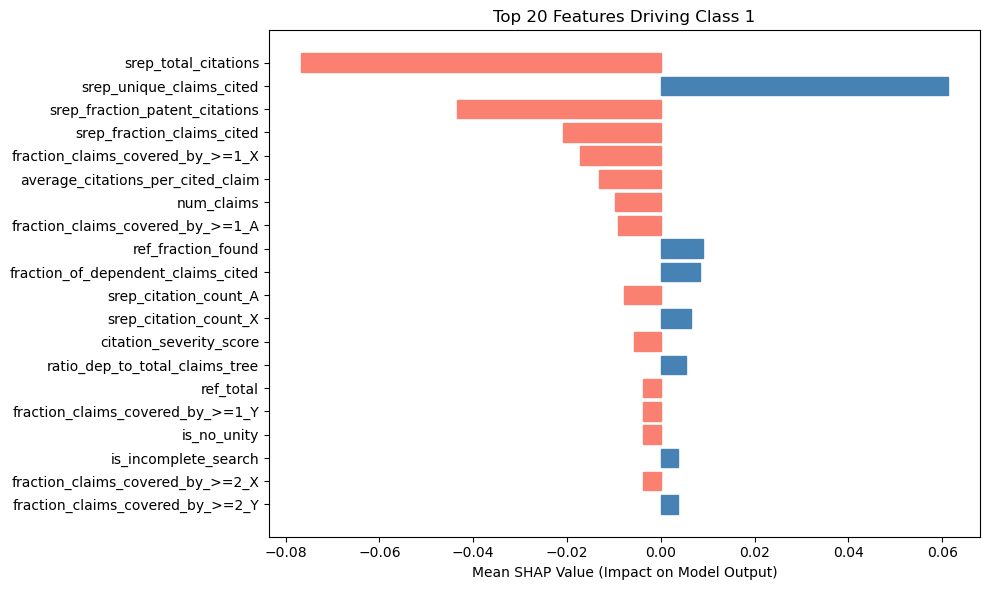

In [158]:
model, explainer, shap_values,label_mapping = shap_summary_best_f1_xgboost(
    results=srep_tree_combined_data_results_dropped,
    df=srep_tree_combined_data_joined_dropped,
    target_col='application_status_target',  # adjust this if your label column is different
    feature_exclude_cols=['publication_date', 'application_number', 'value_imputed']
)